# Analysis Plots (See results notebook for interpretation)

## Imports

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import ast
import plotly.express as px
import mpld3
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import statsmodels.api as sm 
from scipy.stats import ttest_ind
import pickle

# Color codes to use : 
#95a3c3
#e99675
#72b6a1
#db96c0

In [4]:
#Import data
folder = "generated/"
df_movies=pd.read_csv(folder + "final_movie_dataset.csv", index_col = 'Wikipedia movie ID')

#Add a column that has the decades
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

#Add a column that has the seasons
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
df_movies['season'] = df_movies['Movie release month'].apply(month_to_season)

#Add a column that has the release days
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')
df_movies['Movie release day'] = df_movies['Movie release date'].dt.day

df_movies.sample(1)

Unnamed: 0    Movie name  Movie release month  \
Wikipedia movie ID                                                  
32306809                 17240  Yellow Fever                  4.0   

                    Movie release year Movie release date  \
Wikipedia movie ID                                          
32306809                        2011.0         2011-04-13   

                    Movie box office revenue  Movie runtime Movie languages  \
Wikipedia movie ID                                                            
32306809                                 NaN            5.0            ['']   

                   Movie countries    Movie genres Summary Sentiment  \
Wikipedia movie ID                                                     
32306809                      ['']  ['Short Film']     NaN       NaN   

                    Compound Score  vote_average  budget Theme  decade  \
Wikipedia movie ID                                                       
32306809                       NaN           NaN     NaN   NaN  2010.0   

                    season  Movie release day  
Wikipedia movie ID                             
32306809            Spring               13.0

In [5]:
#Add a column with the release day
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')
df_movies['Movie release day'] = df_movies['Movie release date'].dt.day

In [6]:
#Check how many NaN's in each column
df_movies.isna().sum()

Unnamed: 0                      0
Movie name                      0
Movie release month         21171
Movie release year           6834
Movie release date          21171
Movie box office revenue    70535
Movie runtime               20379
Movie languages                 0
Movie countries                 0
Movie genres                    0
Summary                     19378
Sentiment                   19378
Compound Score              19378
vote_average                39682
budget                      73232
Theme                       19605
decade                       6834
season                      21171
Movie release day           21171
dtype: int64

## Data Selection

In [8]:
#Filter df to only keep USA movies and non-nan rows in budget, release year and runtime
df_filtered = df_movies.dropna(subset=['budget', 'Movie box office revenue','Movie release year','Movie runtime'])
df_filtered = df_filtered[df_filtered['Movie countries'].apply(lambda x: 'United States of America' in x)]

#Add profitability metric (box office / budget)
df_filtered['profitability'] = df_filtered['Movie box office revenue']/df_filtered['budget']

#Remove big outliers for better visualization and generalization and small/no budget movies
df_filtered = df_filtered[df_filtered['profitability'] < 15]
df_filtered = df_filtered[df_filtered['budget'] > 10000] 

#Get 1 genre per row
df_filtered['Movie genres'] = df_filtered['Movie genres'].apply(ast.literal_eval)
df_exploded = df_filtered.explode('Movie genres')



In [9]:
#create df with 1 genre per row and filter to keep only USA movies
df_movies['Movie genres'] = df_movies['Movie genres'].apply(ast.literal_eval)

df_genres = df_movies.explode('Movie genres')
df_genres = df_genres.dropna(subset=['Movie release year','Movie runtime','Movie genres'])
df_genres = df_genres[df_genres['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [10]:
#df with all non NaN runtimes and years
df_runtime = df_movies.dropna(subset=['Movie release year','Movie runtime'])
df_runtime = df_runtime[df_runtime['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [11]:
#df with all non NaN release times
df_release = df_movies.dropna(subset=['Movie release year','Movie runtime'])
df_release = df_release[df_release['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [12]:
#df with all non NaN themes
df_theme = df_movies.dropna(subset=['Movie release year','Theme'])
df_theme = df_theme[df_theme['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [13]:
#Number of movies remaining for our study 
print(df_filtered.shape)
print(df_genres.shape)

(4683, 20)
(115075, 19)


In [14]:
#Get the top 10 themes
top_10_themes = df_filtered['Theme'].value_counts().sort_values(ascending=False).head(15)
#print(top_10_themes)

#Define the 6 genres we will study, regrouping all related genres
family_genres = ["Children's/Family",'Family Film','Family-Oriented Adventure','Family Drama','Family & Personal Relationships',"Children's"]
war_genres = ['War film', 'Combat films', 'Anti-War film', 'Gulf War', 'Cold War', 'Nuclear warfare', 'War effort', 'Anti-war']
romantic_genres = ['Romantic thriller','Romantic fantasy','Romantic drama','Romantic comedy']
lgbt_genres = ['LGBT', 'Gay Interest', 'New Queer Cinema', 'Gay Themed', 'Queer Cinema','Gender Issues','Gay']
action_genres = ['Action','Action/Adventure','Action Thrillers','Action Comedy']
superhero_genres = ['Superhero', 'Superhero movie']

#List of genres we will study
genres_list = ['Family','War','Romantic','LGBT','Action','Superhero']

In [15]:
#Rename the movie genres related to the general genres we will study
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(family_genres, 'Family') #1048
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(war_genres, 'War') #250
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(romantic_genres, 'Romantic') #908
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(lgbt_genres, 'LGBT') #233
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(action_genres, 'Action') #2396
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(superhero_genres, 'Superhero') #149

df_genres['Movie genres'] = df_genres['Movie genres'].replace(family_genres, 'Family') #1048
df_genres['Movie genres'] = df_genres['Movie genres'].replace(war_genres, 'War') #250
df_genres['Movie genres'] = df_genres['Movie genres'].replace(romantic_genres, 'Romantic') #908
df_genres['Movie genres'] = df_genres['Movie genres'].replace(lgbt_genres, 'LGBT') #233
df_genres['Movie genres'] = df_genres['Movie genres'].replace(action_genres, 'Action') #2396
df_genres['Movie genres'] = df_genres['Movie genres'].replace(superhero_genres, 'Superhero') #149

In [16]:
#Check sample sizes
df_exploded[df_exploded['Movie genres'] == 'Family'].shape

(1048, 20)

## Does the analysis matter?

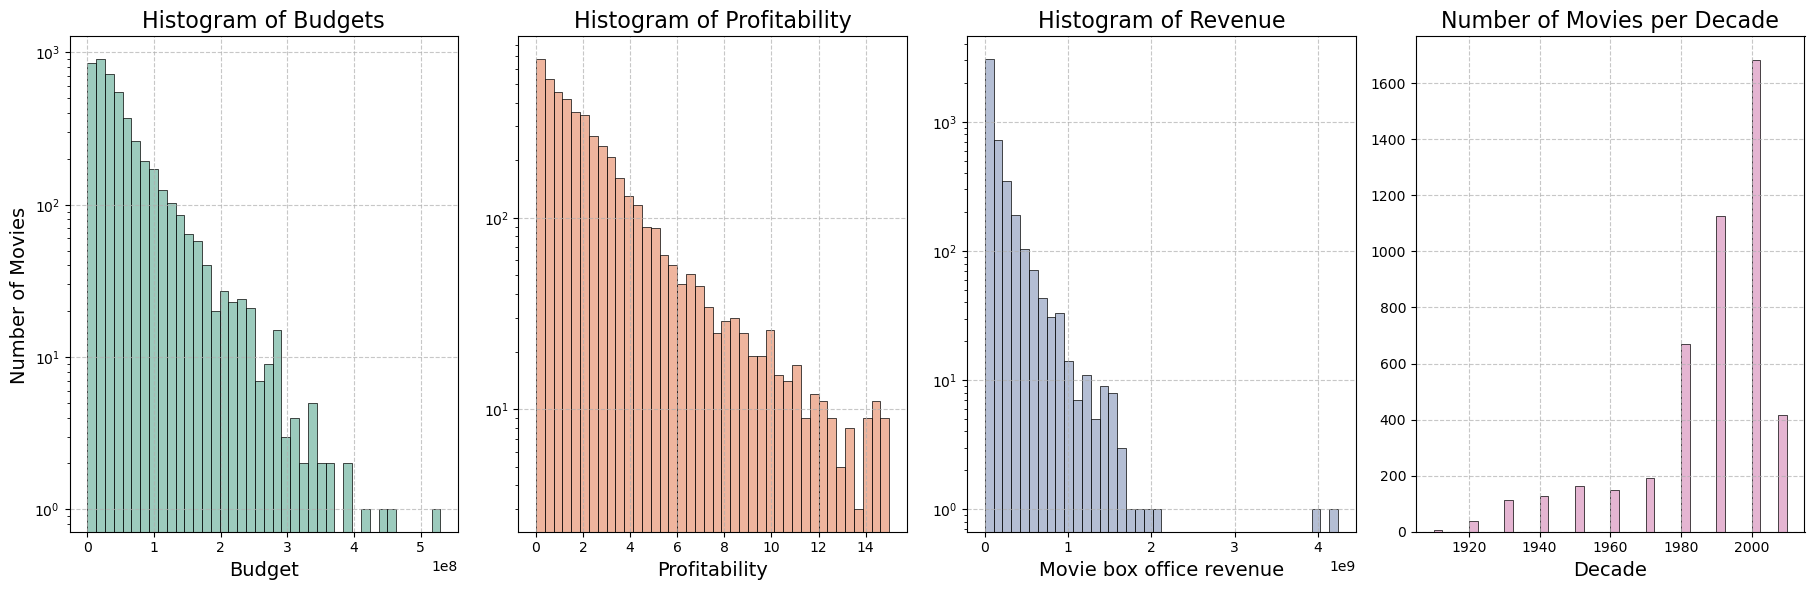

In [18]:
#plot histogram of budgets, profitability, revenue and number of movies per decade

#Create figure
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

#Define info and data of interest for our 4 plots 
variables = ['budget', 'profitability', 'Movie box office revenue', 'decade']
titles = ["Histogram of Budgets", "Histogram of Profitability", "Histogram of Revenue", "Number of Movies per Decade"]
colors = ['#72b6a1', '#e99675', '#95a3c3', '#db96c0']

#Plot all 4 histograms with a loop
for i, (ax, var, title, color) in enumerate(zip(axes, variables, titles, colors)):
    sns.histplot(data=df_filtered, x=var, bins=40, kde=False, color=color, alpha=0.7, ax=ax)
    
    if i < 3:  # Set y-axis to log scale for plots 1, 2 and 3
        ax.set_yscale('log')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(var.capitalize(), fontsize=14)
    ax.set_ylabel("", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
fig.text(0.0, 0.5, 'Number of Movies', ha='center', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.savefig('visuals/nb_movie_budget_profit_BoxOffice_decade.png', bbox_inches='tight')
plt.show()

#Distribution not normal -> we prefer using the median values rather than mean in the following except when the sample size is too small.

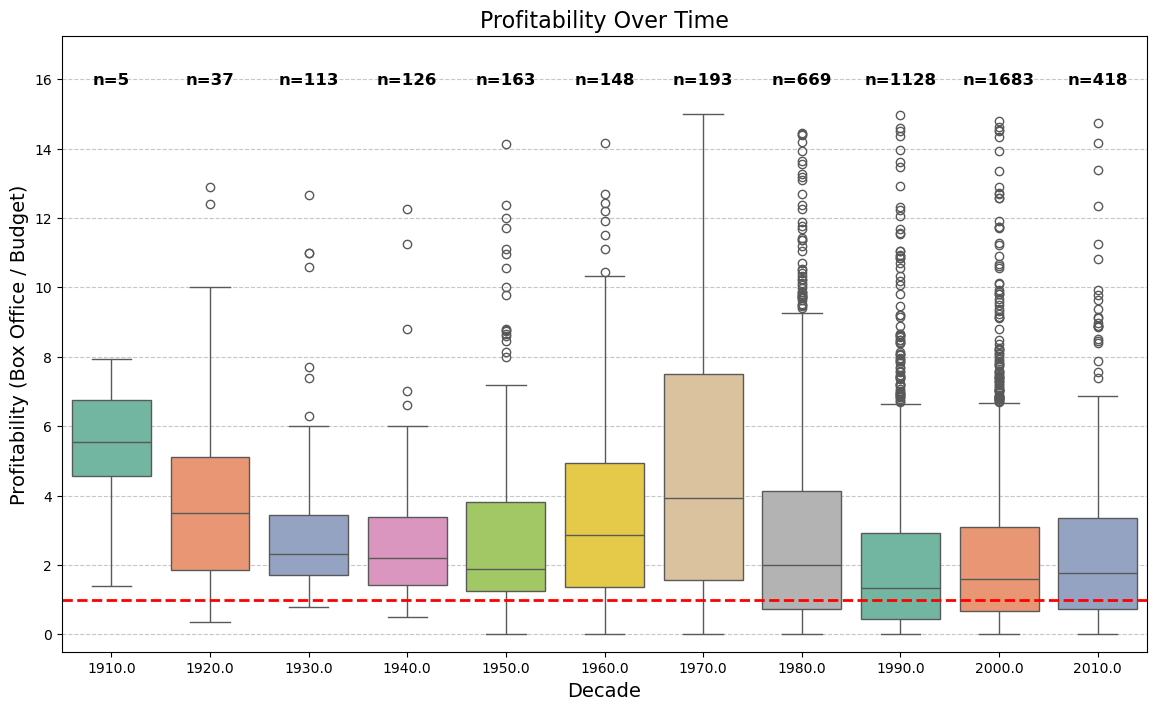

In [19]:
#Boxplot of profitability over time (decade) to see the evolution

#Plot the boxplots
plt.figure(figsize=(14, 8))

sns.boxplot(x="decade",y="profitability",data=df_filtered,legend = False,hue = "decade",palette="Set2")
plt.title("Profitability Over Time", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Profitability (Box Office / Budget)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Add sample count on top
#Positioning of the text
ax = plt.gca()
y_max = df_filtered['profitability'].max()
y_min = df_filtered['profitability'].min() 
y_range = y_max - y_min

counts = df_filtered['decade'].value_counts().sort_index() #number of movies per decade
for i, decade in enumerate(sorted(counts.index)):
    count = counts[decade]
    ax.text(i, y_max + 0.05 * y_range, f'n={count}', ha='center', va='bottom',fontsize=12,fontweight='bold')

#Profitability treshhold at y = 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='y=1')

#Fix Y axis range for better visualization
plt.ylim(y_min-0.5, y_max + 0.15 * y_range)
plt.savefig('visuals/profit_over_time.png', bbox_inches='tight')
plt.show()

#Movies less profitable now than in the past, many even don't turn a profit, we will investigate further...

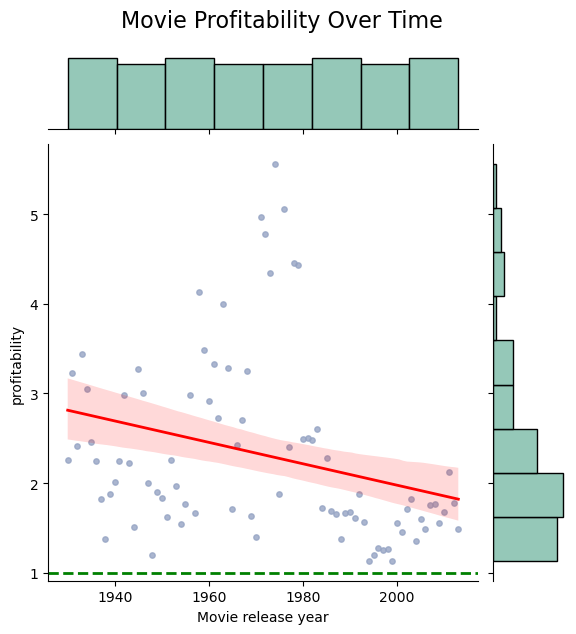

In [20]:
# Confirm the trend with a regression to see if there is a decreasing tendency. 

#Filter to analyze 1930 onwards
df_prof = df_filtered[df_filtered['decade'] > 1929] 

#compute the median profitability for each year: 
#Due to the lack of data in the earlier years, as we want each year to weight equally. 
df_prof_grouped = df_prof.groupby('Movie release year')['profitability'].median().reset_index()

plot = sns.jointplot(x=df_prof_grouped['Movie release year'], y=df_prof_grouped['profitability'], kind="reg",color='#95a3c3',height=6,ratio=5, scatter_kws={'s': 15},line_kws={'color': 'red', 'linewidth': 2},
                     marginal_kws={'kde': False, 'color':'#72b6a1'})

plot.ax_joint.axhline(1, color='green', linestyle='--', linewidth=2)
plot.fig.suptitle("Movie Profitability Over Time", fontsize=16, y=1.05)

plt.savefig('visuals/3.png', bbox_inches='tight')


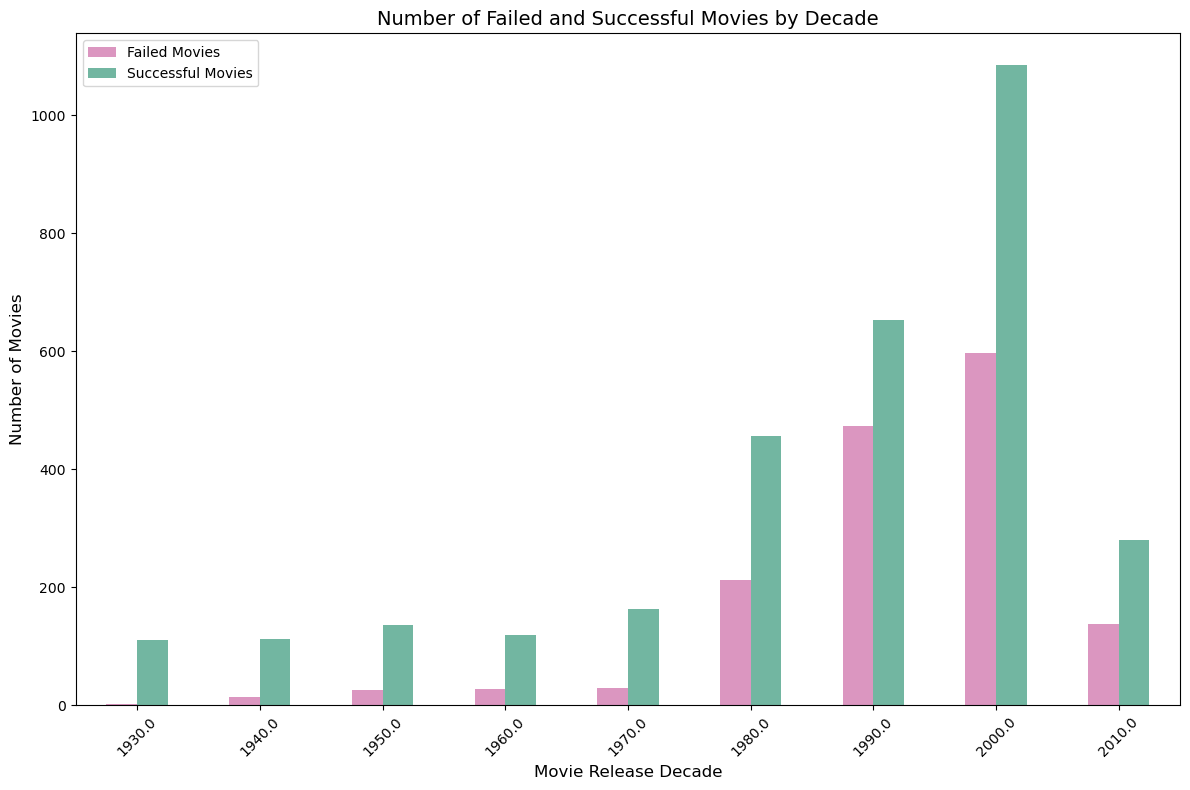

In [21]:
#Add the movie success rate to the dataframe (100 if movie turned a profit, else 0)
df_filtered['success rate'] = np.where(df_filtered['profitability'] > 1, 100, 0)
df_rate_decade = df_filtered[df_filtered['decade'] > 1920]

#Sample count of failed and successful movies per decade
movies_by_decade = df_rate_decade.groupby(['decade', 'success rate']).size().reset_index(name='count')

#Prepare plot data
movies_pivot = movies_by_decade.pivot(index='decade', columns='success rate', values='count').fillna(0)
movies_pivot.columns = ['Failed Movies', 'Successful Movies']

#Barplot
movies_pivot.plot(kind='bar', stacked=False, color=['#db96c0', '#72b6a1'], figsize=(12, 8))

plt.title("Number of Failed and Successful Movies by Decade", fontsize=14)
plt.xlabel("Movie Release Decade", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig('visuals/failed_vs_success_by_decade.png', bbox_inches='tight')
plt.show()


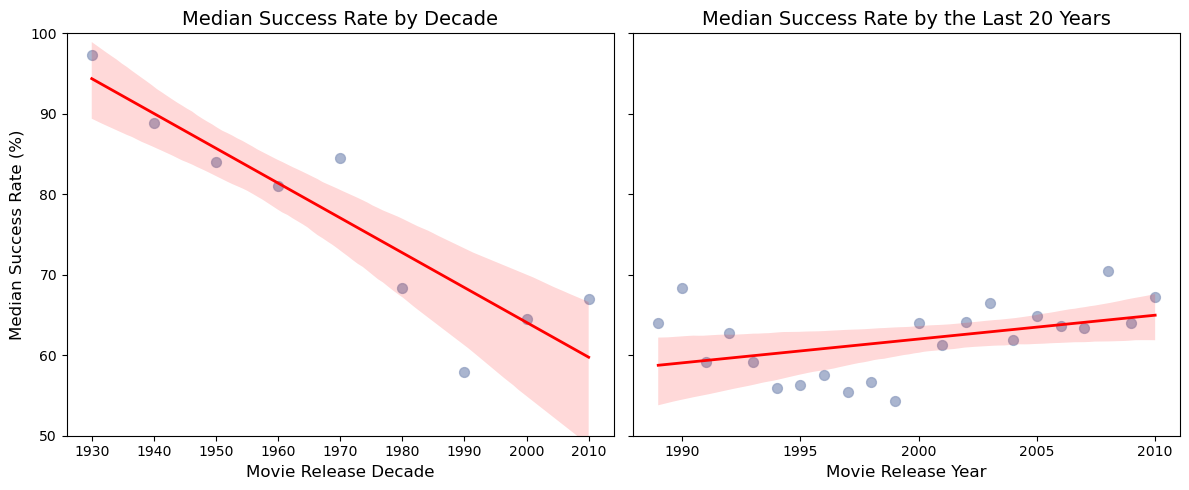

In [22]:
#Regression plot with scatter points and 95% confidence interval showing how the percentage of 
#profitable movies changed over time, for the last 100 and 20 years. 

#Filtering profitability data by decade, as very few data from 100 years ago it gives more samples to compute a meaningful medians/means. 
#profitability data
df_rate_decade = df_filtered[df_filtered['decade'] > 1920]
median_rate_by_decade = df_rate_decade.groupby('decade')['success rate'].mean().reset_index()

#Filter and aggregate success rate data by year for the last 20 years
df_rate_year = df_filtered[(df_filtered['Movie release year'] > 1988) & 
                           (df_filtered['Movie release year'] < 2011)]
median_rate_by_year = df_rate_year.groupby('Movie release year')['success rate'].mean().reset_index()

#plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#Plot 1: Average success rate by decade
sns.regplot(x=median_rate_by_decade['decade'], y=median_rate_by_decade['success rate'], ax=axes[0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0].set_title("Median Success Rate by Decade", fontsize=14)
axes[0].set_xlabel("Movie Release Decade", fontsize=12)
axes[0].set_ylabel("Median Success Rate (%)", fontsize=12)
axes[0].set_ylim(50, 100)

#Plot 2: Average success rate by year
sns.regplot(x=median_rate_by_year['Movie release year'], y=median_rate_by_year['success rate'], ax=axes[1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1].set_title("Median Success Rate by the Last 20 Years", fontsize=14)
axes[1].set_xlabel("Movie Release Year", fontsize=12)
axes[1].set_ylabel("")
axes[1].set_ylim(50, 100)

plt.tight_layout()
plt.savefig('visuals/5.png', bbox_inches='tight')
plt.show()


## Hypothesis 1 : higher budget movies are a higher risk and are less likely to be profitable. 

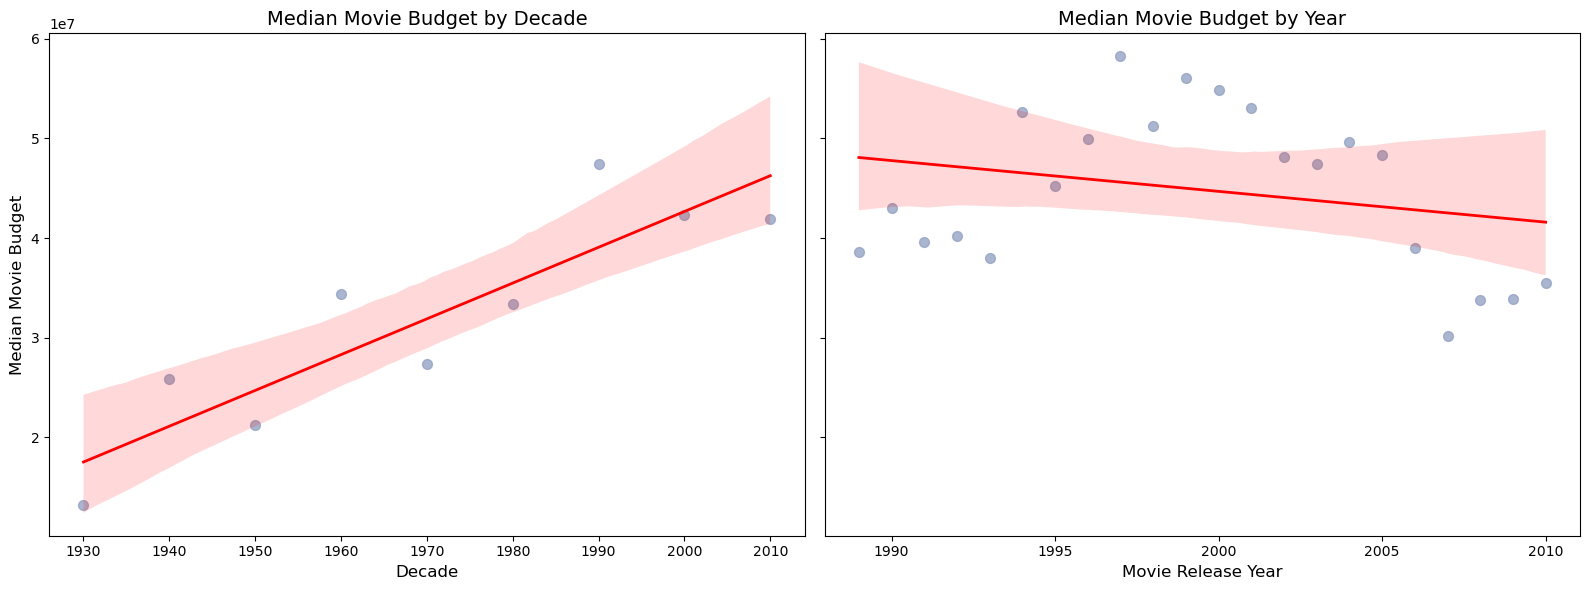

In [24]:
#Plot of budget over time

#Filter to get the data from 1930 onwards and remove outliers for better visualization
#df_budget_decade = df_budget_decade[df_budget_decade['budget'] < 300000000]
df_budget_decade = df_filtered[df_filtered['decade'] > 1929]

#Group by decade and calculate the median runtime
median_budget_per_decade = df_budget_decade.groupby('decade')['budget'].median().reset_index()

#Filter to get the data from the last 20 years as the sample size is bigger, therefore we can see how budgets evolved more recently.
df_budget_year = df_filtered[df_filtered['Movie release year'] > 1988]
df_budget_year = df_budget_year[df_budget_year['Movie release year'] < 2011]

#Group by release year and calculate the median runtime
median_budget_per_year = df_budget_year.groupby('Movie release year')['budget'].median().reset_index()

#Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#Plot 1: Regression on median runtime by decade
sns.regplot(x=median_budget_per_decade['decade'], y=median_budget_per_decade['budget'], ax=axes[0], color='#95a3c3', scatter_kws={'s': 50}, 
            line_kws={'color': 'red', 'linewidth': 2})

axes[0].set_title("Median Movie Budget by Decade", fontsize=14)
axes[0].set_xlabel("Decade", fontsize=12)
axes[0].set_ylabel("Median Movie Budget", fontsize=12)

# Plot 2: Regression on median runtime by release year
sns.regplot(
    x=median_budget_per_year['Movie release year'], 
    y=median_budget_per_year['budget'], 
    ax=axes[1],
    color='#95a3c3', 
    scatter_kws={'s': 50}, 
    line_kws={'color': 'red', 'linewidth': 2}
)
axes[1].set_title("Median Movie Budget by Year", fontsize=14)
axes[1].set_xlabel("Movie Release Year", fontsize=12)
axes[1].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.savefig('visuals/median_budget_by_dec_year.png', bbox_inches='tight')
plt.show()

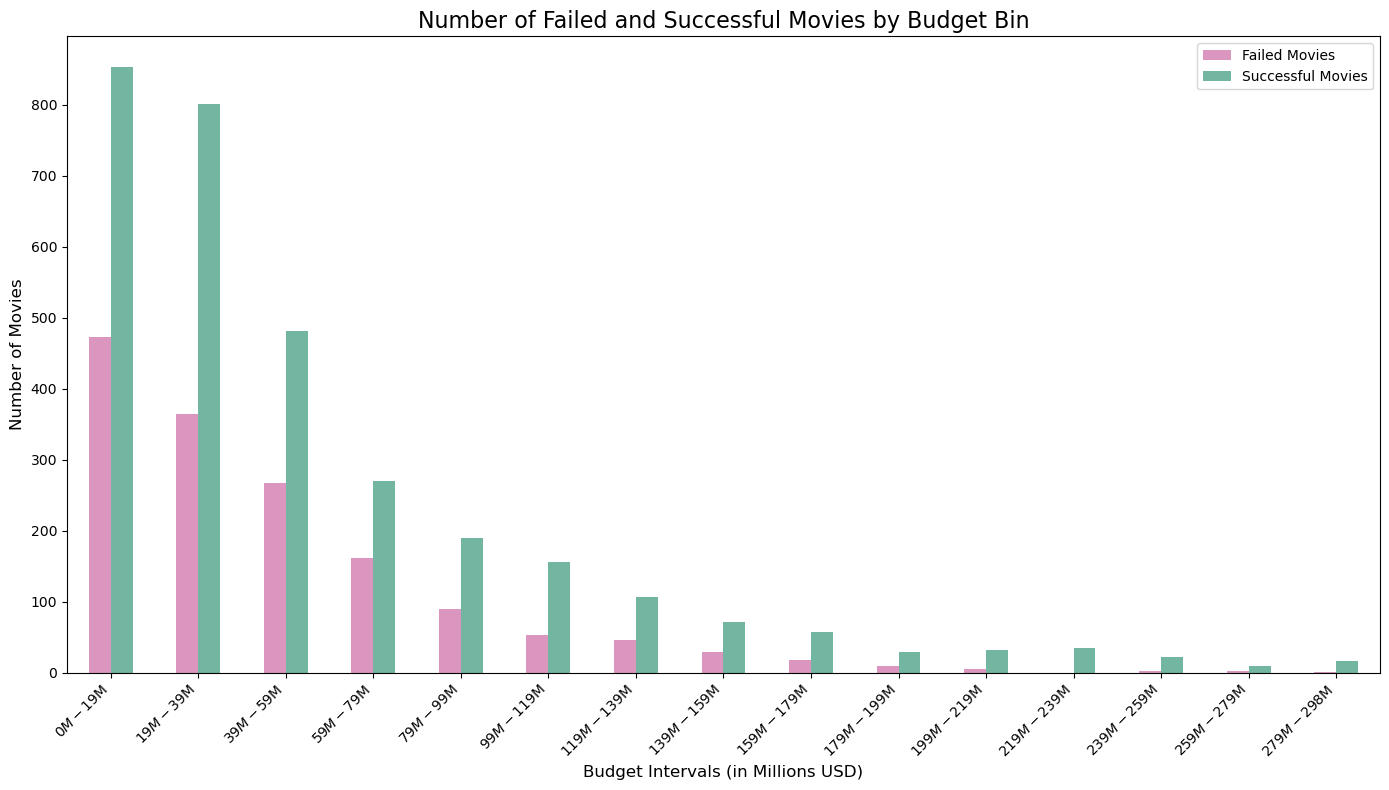

In [25]:
#Barplot for a range of budget the number of failed and successful movies

df_bud = df_filtered[df_filtered['budget'] < 300000000]

#Create bins of budgets as it's a continuous value
budget_bins = pd.cut(df_bud['budget'], bins=15)

#Bin labels for plot
budget_bin_labels = [f"${int(interval.left/1e6):,}M - ${int(interval.right/1e6):,}M" for interval in budget_bins.cat.categories]

#Get number of failed and successful movies per bin
movies_by_budget_bin = df_filtered.groupby([budget_bins, 'success rate'],observed=False).size().reset_index(name='count')

#Prepare data for plotting
movies_pivot_budget = movies_by_budget_bin.pivot(index='budget', columns='success rate', values='count').fillna(0)
movies_pivot_budget.columns = ['Failed Movies', 'Successful Movies']

#Update indices with labels
movies_pivot_budget.index = budget_bin_labels

#Plotting
movies_pivot_budget.plot(kind='bar', stacked=False, color=['#db96c0', '#72b6a1'], figsize=(14, 8))

plt.title("Number of Failed and Successful Movies by Budget Bin", fontsize=16)
plt.xlabel("Budget Intervals (in Millions USD)", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

plt.savefig('visuals/7.png', bbox_inches='tight')
plt.show()


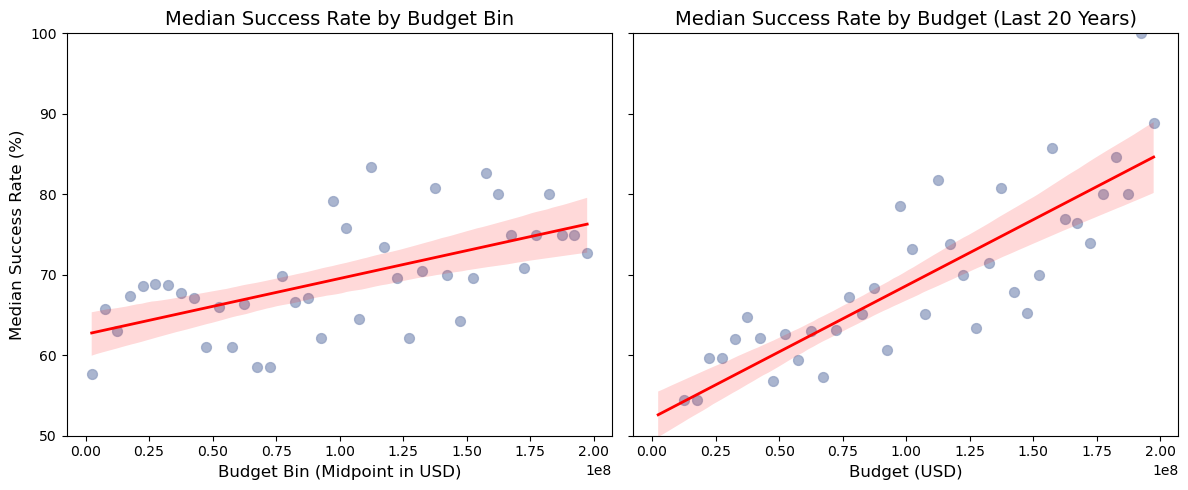

In [26]:
#Do higher budget movies fail more? 

#Remove outliers 
df_bud_old = df_filtered[df_filtered['budget'] < 200000000]

#Visualize trend over a longer period
df_bud_old = df_bud_old[df_bud_old['decade'] > 1929]

#Create bins of budgets as it's a continuous value
budget_bins_old = pd.cut(df_bud_old['budget'], bins=40)

rate_bin_old = df_bud_old.groupby(budget_bins_old, observed=False)['success rate'].mean().reset_index(name='success rate')
rate_bin_old['Budget Midpoint'] = rate_bin_old['budget'].apply(lambda x: x.mid)


#Remove outliers 
df_bud_new = df_filtered[df_filtered['budget'] < 200000000]

#Visualize trend over a longer period
df_bud_new = df_bud_new[df_bud_new['decade'] > 1989]

#Create bins of budgets as it's a continuous value
budget_bins_new = pd.cut(df_bud_new['budget'], bins=40)

rate_bin_new = df_bud_new.groupby(budget_bins_new, observed=False)['success rate'].mean().reset_index(name='success rate')
rate_bin_new['Budget Midpoint'] = rate_bin_new['budget'].apply(lambda x: x.mid)



#Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#Plot 1: Average success rate by budget (all decades)
sns.regplot(x=rate_bin_old['Budget Midpoint'], 
            y=rate_bin_old['success rate'], 
            ax=axes[0], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0].set_title("Median Success Rate by Budget Bin", fontsize=14)
axes[0].set_xlabel("Budget Bin (Midpoint in USD)", fontsize=12)
axes[0].set_ylabel("Median Success Rate (%)", fontsize=12)
axes[0].set_ylim(50, 100)

#Plot 2: Average success rate by budget (last 20 years)
sns.regplot(x=rate_bin_new['Budget Midpoint'], 
            y=rate_bin_new['success rate'], 
            ax=axes[1], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1].set_title("Median Success Rate by Budget (Last 20 Years)", fontsize=14)
axes[1].set_xlabel("Budget (USD)", fontsize=12)
axes[1].set_ylabel("")
axes[1].set_ylim(50, 100)

plt.tight_layout()
plt.savefig('visuals/median_success_rate_by_budget.png', bbox_inches='tight')
plt.show()

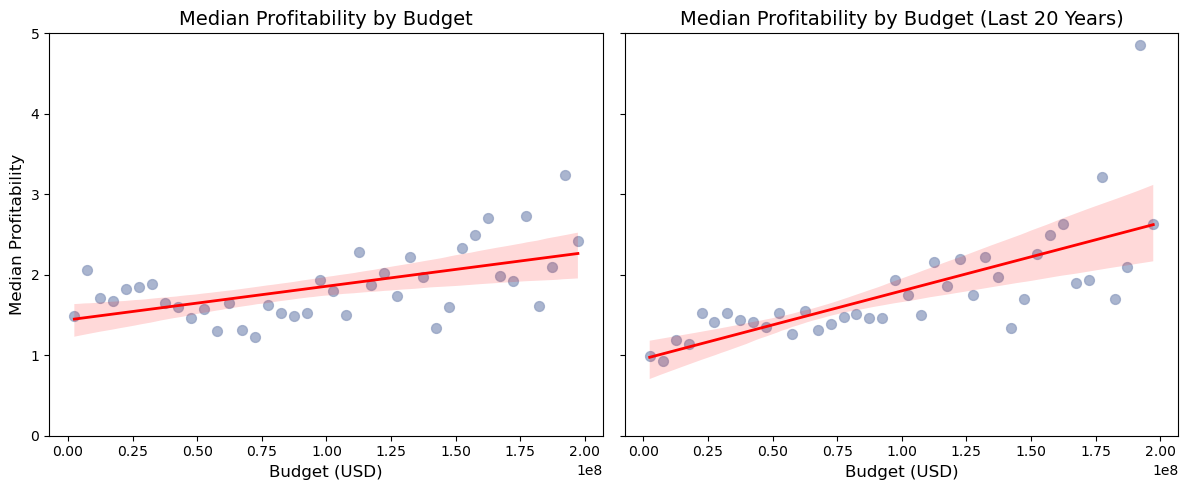

In [27]:
#How does profitability relate to budget? summarizing plot for datastory

#Remove outliers 
df_bud_old = df_filtered[df_filtered['budget'] < 200000000]

#Visualize trend over a longer period
df_bud_old = df_bud_old[df_bud_old['decade'] > 1929]

#Create bins of budgets as it's a continuous value
budget_bins_old = pd.cut(df_bud_old['budget'], bins=40)

rate_bin_old = df_bud_old.groupby(budget_bins_old, observed=False)['profitability'].median().reset_index(name='median profitability')
rate_bin_old['Budget Midpoint'] = rate_bin_old['budget'].apply(lambda x: x.mid)



#Remove outliers 
df_bud_new = df_filtered[df_filtered['budget'] < 200000000]

#Visualize trend over a longer period
df_bud_new = df_bud_new[df_bud_new['decade'] > 1989]

#Create bins of budgets as it's a continuous value
budget_bins_new = pd.cut(df_bud_new['budget'], bins=40)

rate_bin_new = df_bud_new.groupby(budget_bins_new, observed=False)['profitability'].median().reset_index(name='median profitability')
rate_bin_new['Budget Midpoint'] = rate_bin_new['budget'].apply(lambda x: x.mid)



#Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#Plot 1: Median profitability by budget (all decades)
sns.regplot(x=rate_bin_old['Budget Midpoint'], 
            y=rate_bin_old['median profitability'], 
            ax=axes[0], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0].set_title("Median Profitability by Budget", fontsize=14)
axes[0].set_xlabel("Budget (USD)", fontsize=12)
axes[0].set_ylabel("Median Profitability", fontsize=12)
axes[0].set_ylim(0, 5)

#Plot 2: Median profitability by budget (last 20 years)
sns.regplot(x=rate_bin_new['Budget Midpoint'], 
            y=rate_bin_new['median profitability'], 
            ax=axes[1], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1].set_title("Median Profitability by Budget (Last 20 Years)", fontsize=14)
axes[1].set_xlabel("Budget (USD)", fontsize=12)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.savefig('visuals/9.png', bbox_inches='tight')
plt.show()

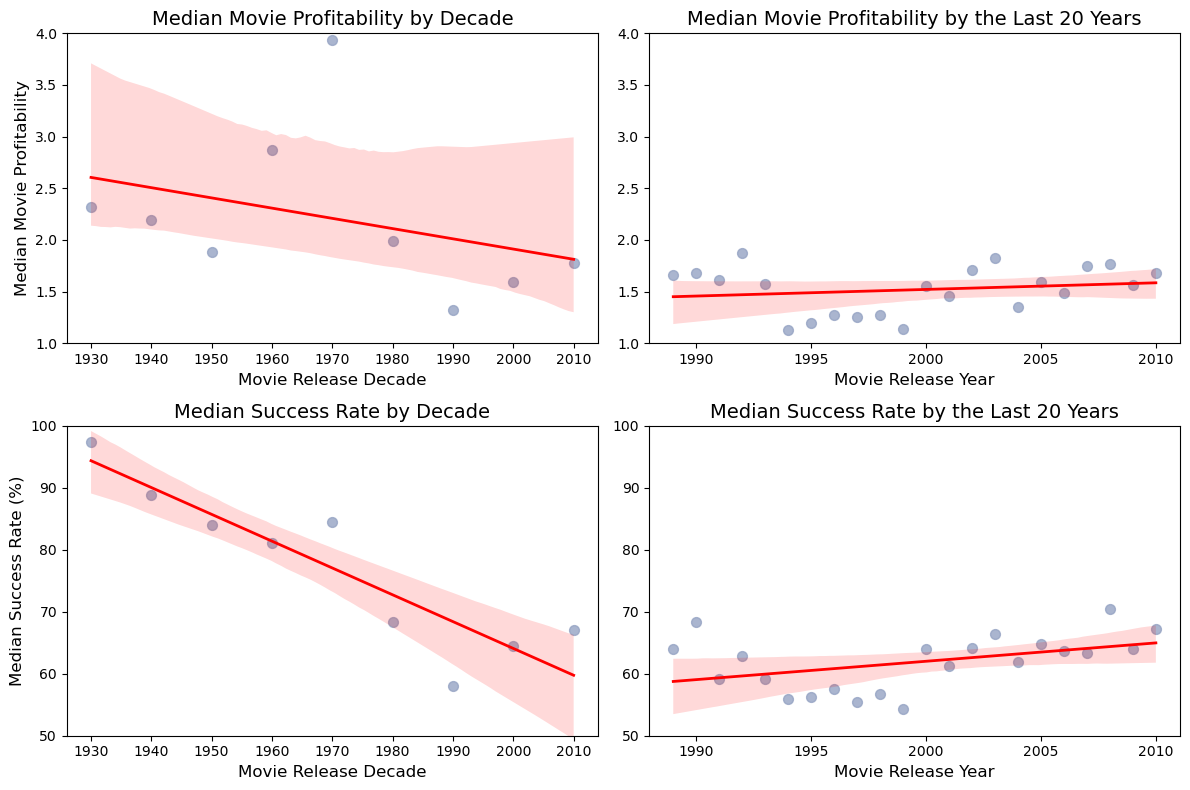

In [28]:
#Regression plot with scatter points and 95% confidence interval representing how the movie profitability evolved over time, and how the percentage of 
# profitable movies changed over time, for the last 100 and 20 years. 


#Add the movie success rate to the dataframe (100 if movie turned a profit, else 0)
df_filtered['success rate'] = np.where(df_filtered['profitability'] > 1, 100, 0)

#Filtering profitability data by decade, as very few data from 100 years ago it gives more samples to compute a meaningful medians/means. 
#profitability data
df_profitability_decade = df_filtered.copy()
df_profitability_decade = df_profitability_decade[df_profitability_decade['profitability'] < 15]
df_profitability_decade = df_profitability_decade[df_profitability_decade['decade'] > 1920]

median_profitability_per_decade = df_profitability_decade.groupby('decade')['profitability'].median().reset_index()

#success rate data
df_rate_decade = df_filtered.copy()
df_rate_decade = df_rate_decade[df_rate_decade['decade'] > 1920] 

median_rate_by_decade = df_rate_decade.groupby('decade')['success rate'].mean().reset_index()

#To observe the more recent evolution, we compute the medians per year for the last 20 years
#profitability data
df_profitability_year = df_filtered.copy()
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] > 1988]
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] < 2011]

median_profitability_per_year = df_profitability_year.groupby('Movie release year')['profitability'].median().reset_index()

#success rate data
df_rate_year = df_filtered.copy()
df_rate_year = df_rate_year[df_rate_year['Movie release year'] > 1988] 
df_rate_year = df_rate_year[df_rate_year['Movie release year'] < 2011] 

median_rate_by_year = df_rate_year.groupby('Movie release year')['success rate'].mean().reset_index()


#Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)

#Plot 1: Median Movie Profitability by Decade
sns.regplot(x=median_profitability_per_decade['decade'], y=median_profitability_per_decade['profitability'], ax=axes[0, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 0].set_title("Median Movie Profitability by Decade", fontsize=14)
axes[0, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[0, 0].set_ylabel("Median Movie Profitability", fontsize=12)
axes[0, 0].set_ylim(1, 4)

#Plot 2: Median Movie Profitability by Year
sns.regplot(x=median_profitability_per_year['Movie release year'], y=median_profitability_per_year['profitability'], ax=axes[0, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 1].set_title("Median Movie Profitability by the Last 20 Years", fontsize=14)
axes[0, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[0, 1].set_ylabel("")
axes[0, 1].set_ylim(1, 4)

#Plot 3: Average Success Rate by Decade
sns.regplot(x=median_rate_by_decade['decade'], y=median_rate_by_decade['success rate'], ax=axes[1, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 0].set_title("Median Success Rate by Decade", fontsize=14)
axes[1, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[1, 0].set_ylabel("Median Success Rate (%)", fontsize=12)
axes[1, 0].set_ylim(50, 100)

#Plot 4: Average Success Rate by Year
sns.regplot(x=median_rate_by_year['Movie release year'], y=median_rate_by_year['success rate'], ax=axes[1, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 1].set_title("Median Success Rate by the Last 20 Years", fontsize=14)
axes[1, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[1, 1].set_ylabel("")
axes[1, 1].set_ylim(50, 100)

plt.tight_layout()
plt.savefig('visuals/ds_2_profbydecade.png', bbox_inches='tight')
plt.show()

## Hypothesis 2: Does movie runtime influence revenue?

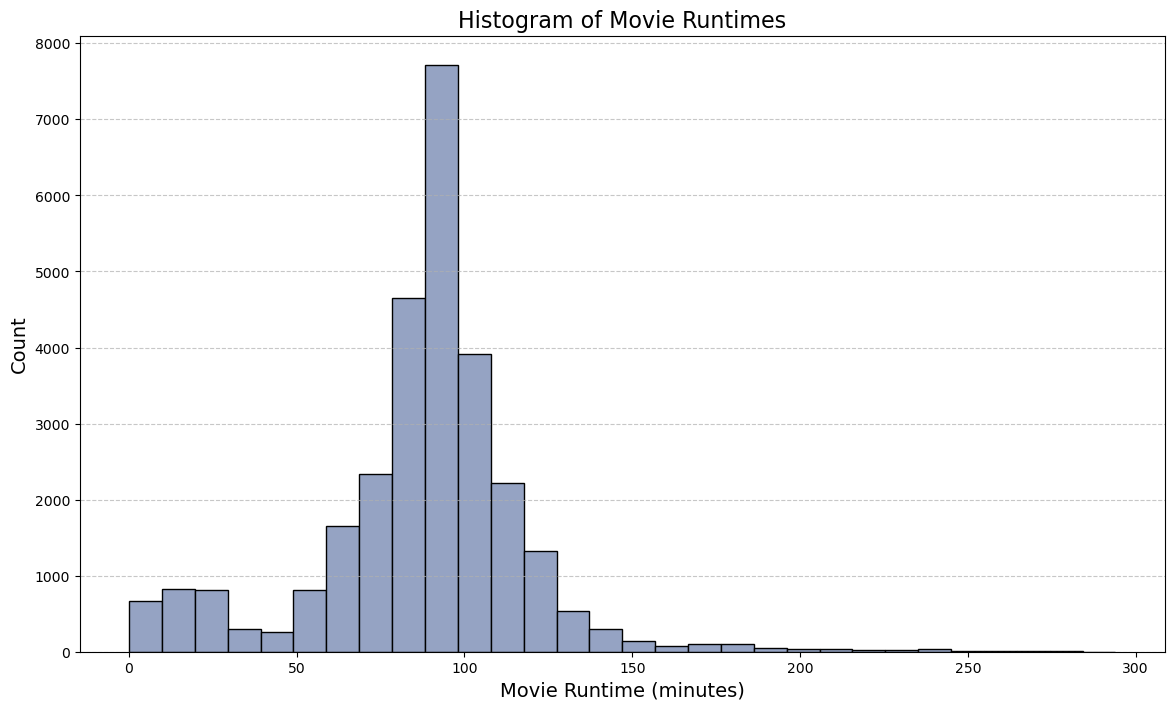

In [30]:
#Histogram of runtimes (we use the dataset with the most data : which include NaN budget/revenues)

#remove outliers for better visualisation
df_run = df_runtime[df_runtime['Movie runtime'] < 300] 
#df_run = df_run[df_run['decade'] > 1929]

#Plotting
plt.figure(figsize=(14, 8))
plt.hist(df_run['Movie runtime'], bins=30, color='#95a3c3', edgecolor='black')

plt.title("Histogram of Movie Runtimes", fontsize=16)
plt.xlabel("Movie Runtime (minutes)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and show the plot
plt.savefig('visuals/nb_movie_per_runtime.png', bbox_inches='tight')
plt.show()

#Normally distributed around 1h30 mark +-

(28980, 19)


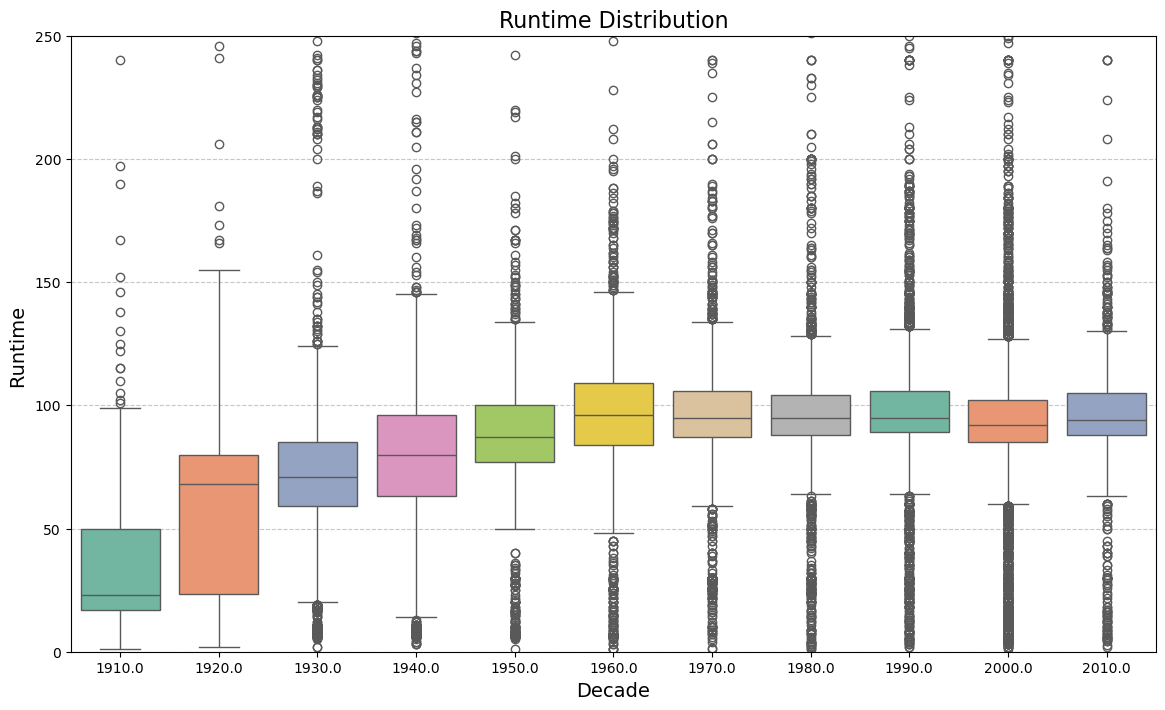

In [31]:
#Boxplot of runtimes for each decade
#We still use the extended dataset

df_filtered['decade'] = df_filtered['decade'].astype(int)

#Filter for better visualisation
df_run = df_runtime[df_runtime['decade'] > 1909]

print(df_run.shape)

#Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(x="decade", y="Movie runtime", data=df_run, legend = False, hue = "decade", palette="Set2")

plt.title("Runtime Distribution", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Runtime ", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 250)

plt.savefig('visuals/runtime_distribution_per_decade.png', bbox_inches='tight')
plt.show()


(20146, 19)


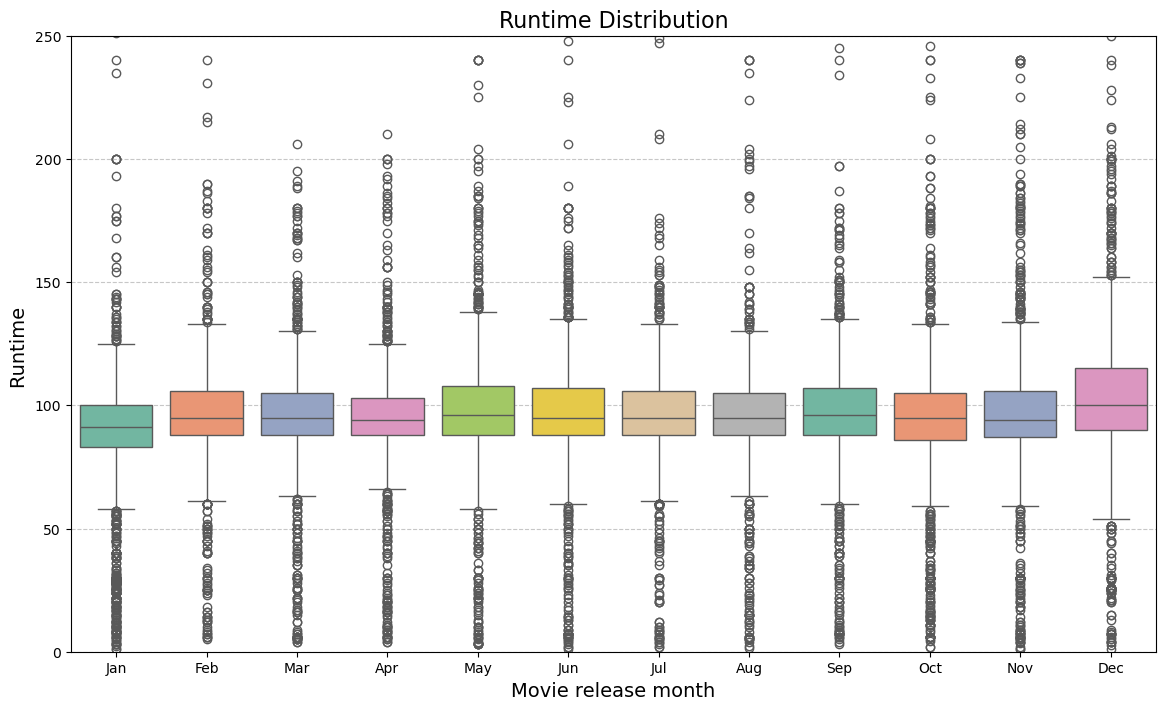

In [32]:
#Boxplot of runtimes for each decade
#We still use the extended dataset

df_filtered['decade'] = df_filtered['decade'].astype(int)

#Filter for better visualisation
df_run = df_runtime[df_runtime['decade'] > 1959]

print(df_run.shape)

#Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(x="Movie release month", y="Movie runtime", data=df_run, legend = False, hue = "Movie release month", palette="Set2")

plt.title("Runtime Distribution", fontsize=16)
plt.xlabel("Movie release month", fontsize=14)
plt.ylabel("Runtime ", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 250)

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(0,11,12), labels=month_names)

plt.savefig('visuals/runtime_distribution_per_month.png', bbox_inches='tight')
plt.show()

#constant runtime through time, except in the 60s. She keeps it in mind to investigate later...

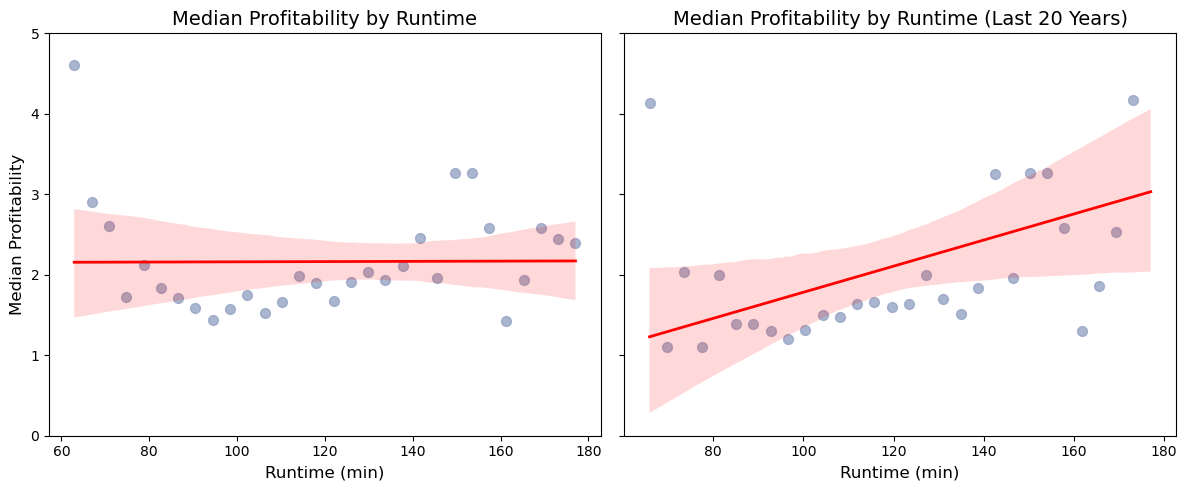

In [33]:
#How does profitability relate to runtime? 

#Filter range with the most datapoints (which is considered a classic movie length)
df_run_old = df_filtered[df_filtered['Movie runtime'] < 180]
df_run_old = df_run_old[df_run_old['Movie runtime'] > 60]

#Visualize trend over a longer period
df_run_old = df_run_old[df_run_old['decade'] > 1929]

#Create bins of runtimes as it's a continuous value
runtime_bins_old = pd.cut(df_run_old['Movie runtime'], bins=30)

rate_bin_old = df_run_old.groupby(runtime_bins_old, observed=False)['profitability'].median().reset_index(name='median profitability')
rate_bin_old['Runtime Midpoint'] = rate_bin_old['Movie runtime'].apply(lambda x: x.mid)


#Filter range with the most datapoints (which is considered a classic movie length)
df_run_new = df_filtered[df_filtered['Movie runtime'] < 180]
df_run_new = df_run_new[df_run_new['Movie runtime'] > 60]

#Visualize trend over a shorter period
df_run_new = df_run_new[df_run_new['decade'] > 1989]

#Create bins of runtimes as it's a continuous value
runtime_bins_new = pd.cut(df_run_new['Movie runtime'], bins=30)

rate_bin_new = df_run_new.groupby(runtime_bins_new, observed=False)['profitability'].median().reset_index(name='median profitability')
rate_bin_new['Runtime Midpoint'] = rate_bin_new['Movie runtime'].apply(lambda x: x.mid)



#Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#Plot 1: Median budget by runtime (all decades)
sns.regplot(x=rate_bin_old['Runtime Midpoint'], 
            y=rate_bin_old['median profitability'], 
            ax=axes[0], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0].set_title("Median Profitability by Runtime", fontsize=14)
axes[0].set_xlabel("Runtime (min)", fontsize=12)
axes[0].set_ylabel("Median Profitability", fontsize=12)
axes[0].set_ylim(0, 5)

#Plot 2: Median budget by runtime (last 20 years)
sns.regplot(x=rate_bin_new['Runtime Midpoint'], 
            y=rate_bin_new['median profitability'], 
            ax=axes[1], color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1].set_title("Median Profitability by Runtime (Last 20 Years)", fontsize=14)
axes[1].set_xlabel("Runtime (min)", fontsize=12)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.savefig('visuals/median_profit_by_runtime.png', bbox_inches='tight')
plt.show()

## Hypothesis 3: what is the most profitable release period?


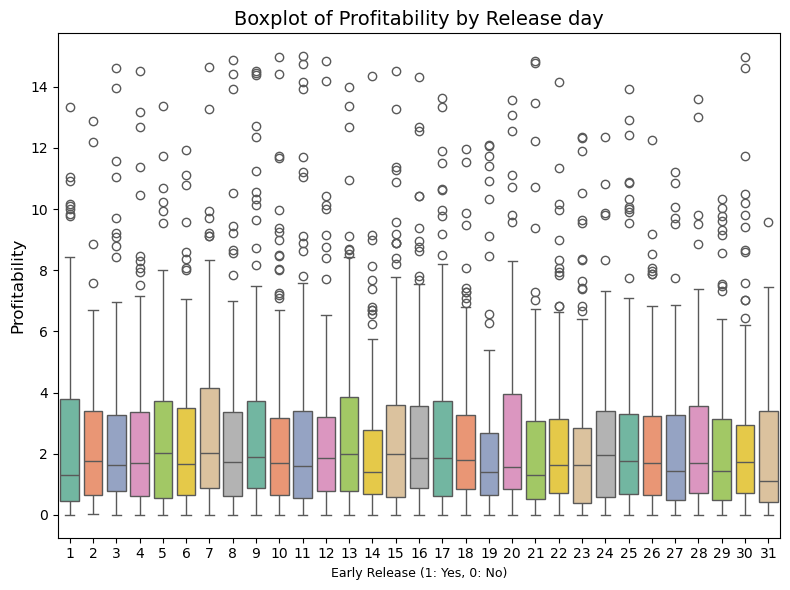

In [36]:
#Does when you release movies within a month have an impact on profitability?
#Boxplot of profitability on release day

#Add a "day" column and look from 1950 onwards
df_filtered['Movie release day'] = df_filtered['Movie release day'].astype(int)
df_prof = df_filtered[df_filtered['decade'] > 1950]

#Plotting 
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_prof['Movie release day'], y=df_prof['profitability'], hue = df_prof['Movie release day'], palette='Set2', legend = None)

plt.xlabel("Early Release (1: Yes, 0: No)", fontsize=9)
plt.ylabel("Profitability", fontsize=12)
plt.title("Boxplot of Profitability by Release day", fontsize=14)

plt.tight_layout()
plt.savefig('visuals/profit_per_day.png', bbox_inches='tight')
plt.show()

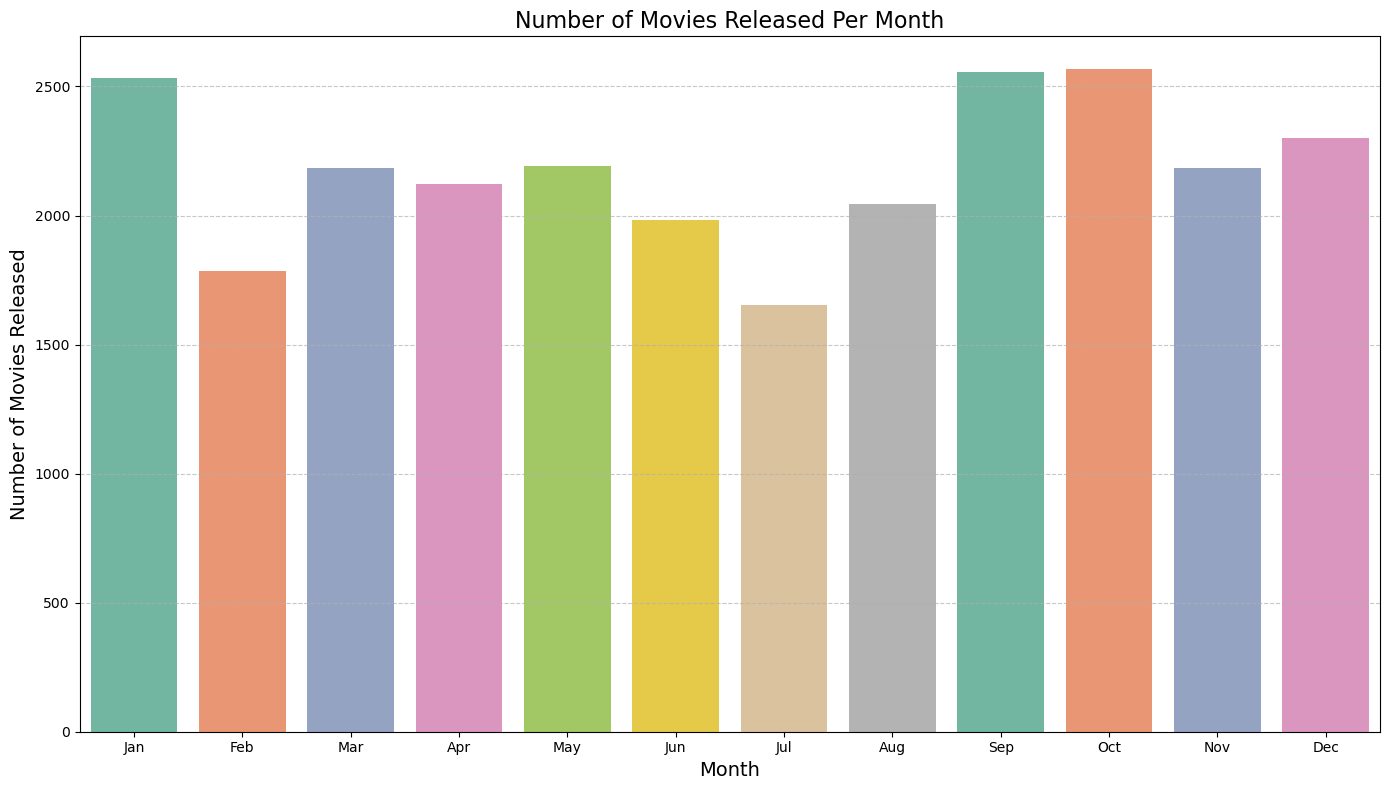

In [37]:
#Number of movies released for each month in our dataset

#Count the number of movies per month, independent of the release year
df_rel = df_release[df_release['decade'] > 1900]
movie_counts = df_rel['Movie release month'].value_counts().sort_index()

#Ploting
plt.figure(figsize=(14, 8))
sns.barplot(x=movie_counts.index, y=movie_counts.values, palette="Set2", legend = False, hue = movie_counts.index)

plt.title("Number of Movies Released Per Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Movies Released", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.arange(12), labels=month_names)

plt.tight_layout()
plt.savefig('visuals/nb_movie_per_month.png', bbox_inches='tight')
plt.show()

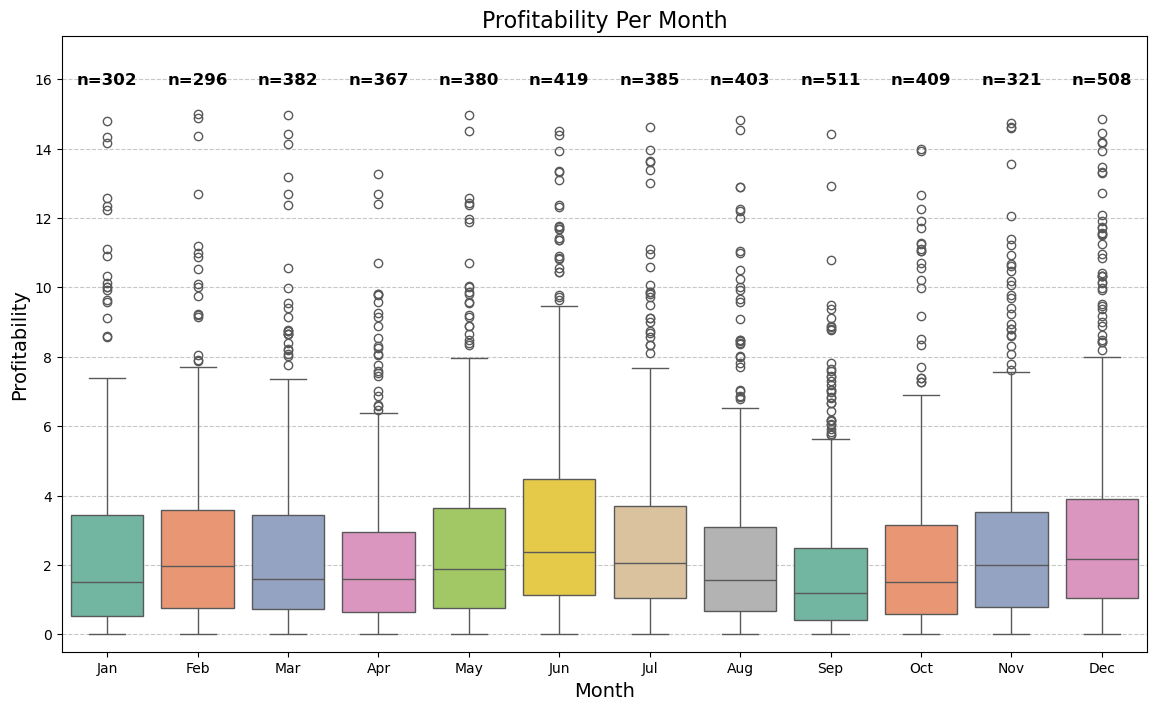

In [38]:
#Boxplot of profitability per month (independent from release year)

#plotting
plt.figure(figsize=(14, 8))

sns.boxplot(x="Movie release month",y="profitability",data=df_filtered,legend = False,hue = "Movie release month",palette="Set2")

plt.title("Profitability Per Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Profitability", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Add number of samples per month (we have lesser samples than in the previous plot, as there is a lot of missing budgets and revenues
counts = df_filtered['Movie release month'].value_counts().sort_index()
ax = plt.gca()  
y_max = df_filtered['profitability'].max()
y_min = df_filtered['profitability'].min()
y_range = y_max - y_min

for i, decade in enumerate(sorted(counts.index)):
    count = counts[decade]
    ax.text(i, y_max + 0.05 * y_range,  f'n={count}', ha='center', va='bottom',fontsize=12,fontweight='bold')

plt.ylim(y_min-0.5, y_max + 0.15 * y_range)

#Change the numerical x labels to their corresponding month
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(0,11,12), labels=month_names)
plt.savefig('visuals/profit_per_month.png', bbox_inches='tight')
plt.show()

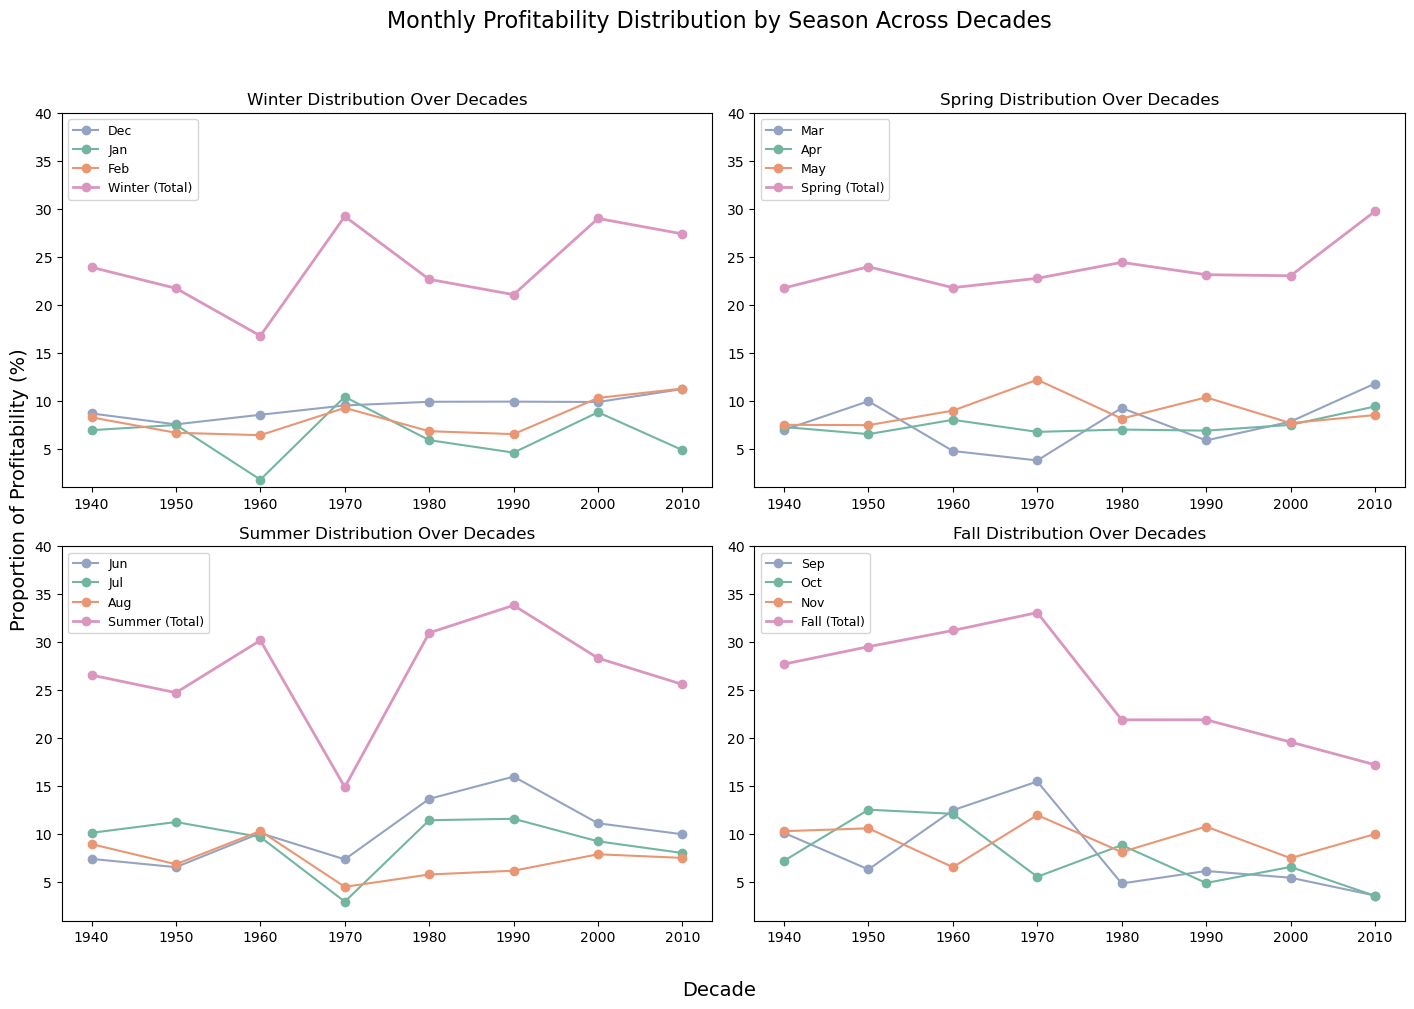

In [39]:
#Line plot showing the proportion of profitability achieved each month for a given decade, grouped by season to observe trends over time.

#preparation of the data : table that for each decade and month, gives the median profitability
df_data = df_filtered[df_filtered['decade']>1930]
data = df_data.pivot_table(index="decade", columns="Movie release month", values="profitability", aggfunc="median").fillna(0)

#Make the data proportional per month, to see how much a given month contributes to the total profitability of a given decade
data_proportional = data.div(data.sum(axis=1), axis=0)*100
counts = df_data['decade'].value_counts().sort_index()

#Names and colors for the line plots
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
seasons = {"Winter": [12, 1, 2], "Spring": [3, 4, 5], "Summer": [6, 7, 8], "Fall": [9, 10, 11]}
colors = ['#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3']

#Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    ax = axes[i]

    #Plot months
    for month in months:
        ax.plot(data_proportional.index, data_proportional[month], label=month_names[month-1], marker="o", color=colors[month-1])

    #Plot seasons
    season_sum = data_proportional[months].sum(axis=1)
    ax.plot(data_proportional.index, season_sum, label=f"{season_name} (Total)", color="#db96c0", linewidth=2, linestyle="-", marker="o")

    ax.set_title(f"{season_name} Distribution Over Decades", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(loc="upper left", fontsize=9)
    ax.set_ylim(1, 40)

fig.text(0.0, 0.5, 'Proportion of Profitability (%)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0, 'Decade', ha='center', va='center', rotation='horizontal', fontsize=14)

fig.suptitle("Monthly Profitability Distribution by Season Across Decades", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('visuals/17.png', bbox_inches='tight')
plt.show()


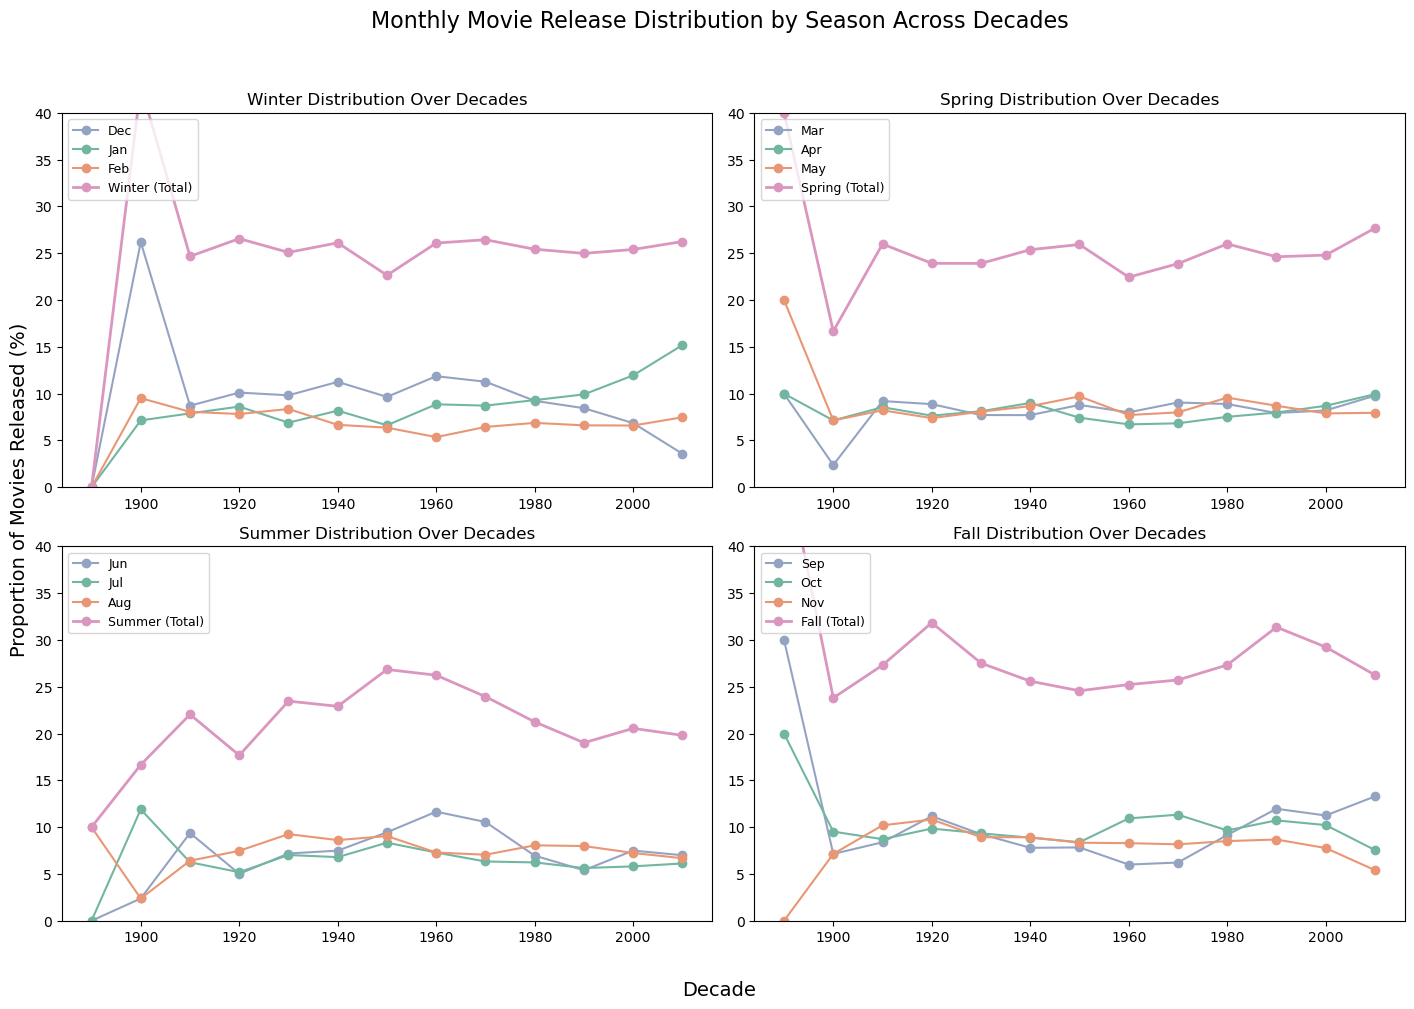

In [40]:
#Line plot showing the proportion of movies released per month for a given decade, grouped by season to observe trends over time.
df_release_counts = df_release.groupby(['decade', 'Movie release month']).size().reset_index(name='count')

#preparation of the data : table that for each decade and month, gives the median profitability
df_release_counts['proportion'] = df_release_counts.groupby('decade')['count'].transform(lambda x: x / x.sum()) * 100
df_release_counts = df_release_counts.sort_values(by='decade', ascending=False)
data_proportional = df_release_counts.pivot(index="decade", columns="Movie release month", values="proportion").fillna(0)

#Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    ax = axes[i]
    for month in months:
        ax.plot(data_proportional.index, data_proportional[month], label=month_names[month - 1], marker="o", color=colors[month - 1])
    season_sum = data_proportional[months].sum(axis=1)
    ax.plot(data_proportional.index, season_sum, label=f"{season_name} (Total)", color="#db96c0", linewidth=2, linestyle="-", marker="o")
    ax.set_title(f"{season_name} Distribution Over Decades", fontsize=12)
    ax.legend(loc="upper left", fontsize=9)
    ax.set_ylim(0, 40)


fig.text(0.0, 0.5, 'Proportion of Movies Released (%)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0, 'Decade', ha='center', va='center', rotation='horizontal', fontsize=14)
fig.suptitle("Monthly Movie Release Distribution by Season Across Decades", fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('visuals/18.png', bbox_inches='tight')
plt.show()



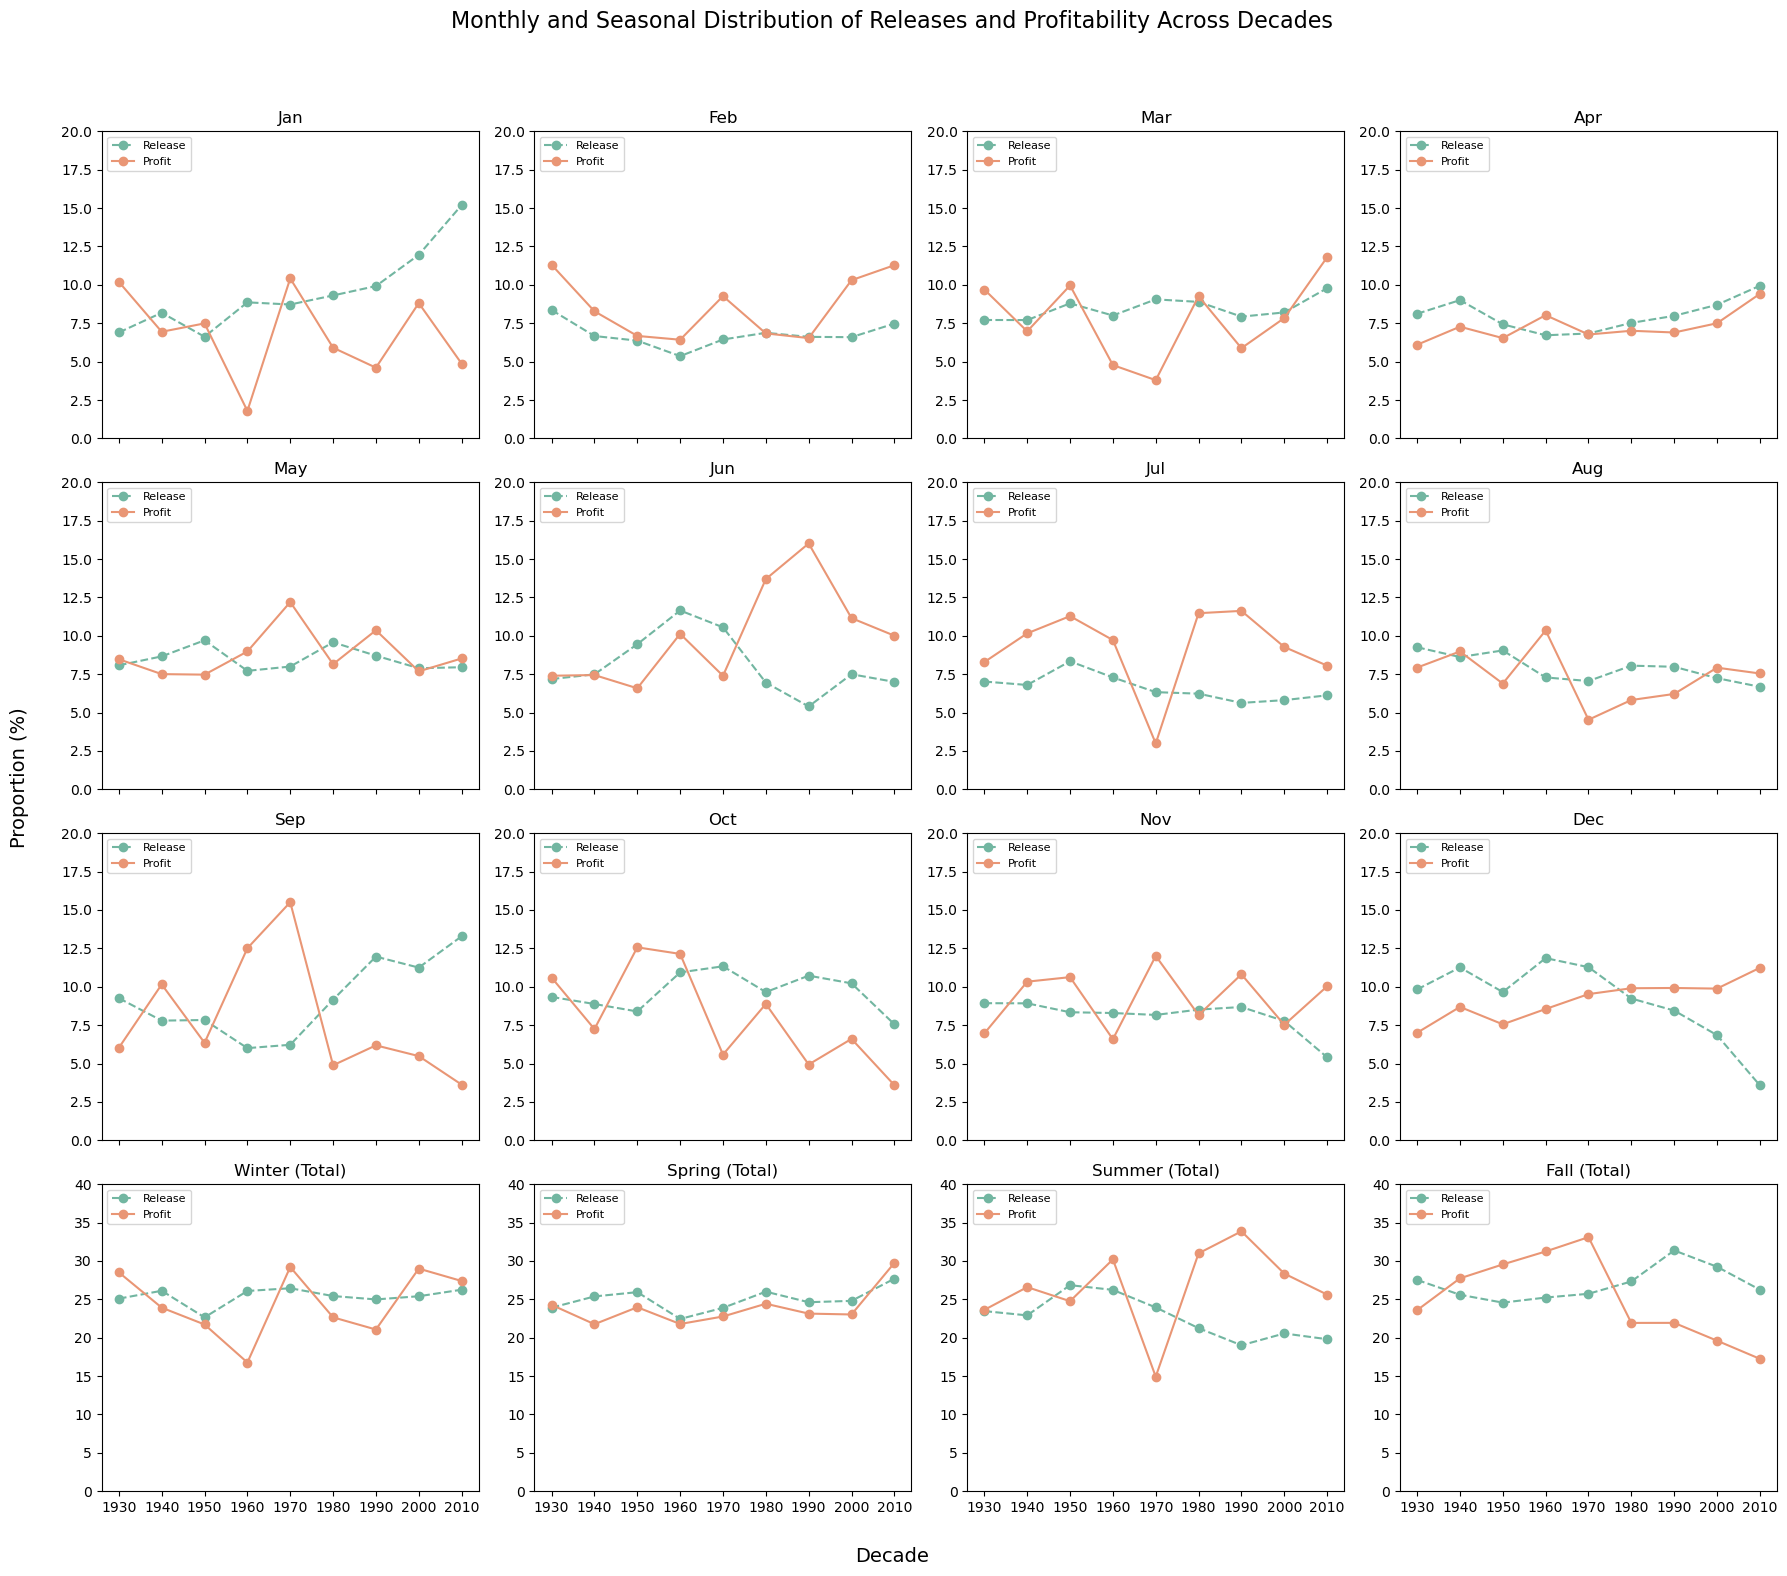

In [41]:
#Comparison of proportions of profitability and movies released. 

#Prepare release data
df_rel = df_release[df_release['decade']> 1929]
df_release_counts = df_rel.groupby(['decade', 'Movie release month']).size().reset_index(name='count')
df_release_counts['proportion'] = df_release_counts.groupby('decade')['count'].transform(lambda x: x / x.sum()) * 100
df_release_counts = df_release_counts.sort_values(by='decade', ascending=False)
data_release = df_release_counts.pivot(index="decade", columns="Movie release month", values="proportion").fillna(0)

#Prepare profitability data
df_data = df_filtered[df_filtered['decade'] > 1929]
data_profitability = df_data.pivot_table(index="decade", columns="Movie release month", values="profitability", aggfunc="median").fillna(0)
data_profitability = data_profitability.div(data_profitability.sum(axis=1), axis=0) * 100

#Plotting
fig, axes = plt.subplots(4, 4, figsize=(18, 16), sharex=True, sharey=False)
axes = axes.flatten()

#1 plot per month
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    ax.plot(data_release.index, data_release[month], label="Release", marker="o", linestyle="--", color="#72b6a1")
    ax.plot(data_profitability.index, data_profitability[month], label="Profit", marker="o", linestyle="-", color="#e99675")
    ax.set_title(month_names[month - 1], fontsize=12)
    ax.legend(loc="upper left", fontsize=8)
    ax.set_ylim(0, 20)

#1 plot per season
for i, (season_name, months) in enumerate(seasons.items(), start=12):
    ax = axes[i]
    release_season_sum = data_release[months].sum(axis=1)
    profit_season_sum = data_profitability[months].sum(axis=1)
    ax.plot(data_release.index, release_season_sum, label="Release", marker="o", linestyle="--", color="#72b6a1")
    ax.plot(data_profitability.index, profit_season_sum, label="Profit", marker="o", linestyle="-", color="#e99675")
    ax.set_title(f"{season_name} (Total)", fontsize=12)
    ax.legend(loc="upper left", fontsize=8)
    ax.set_ylim(0, 40)

fig.text(0.5, 0.01, 'Decade', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Proportion (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Monthly and Seasonal Distribution of Releases and Profitability Across Decades", fontsize=16)

fig.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig('visuals/month_season_profit_releases.png', bbox_inches='tight')
plt.show()


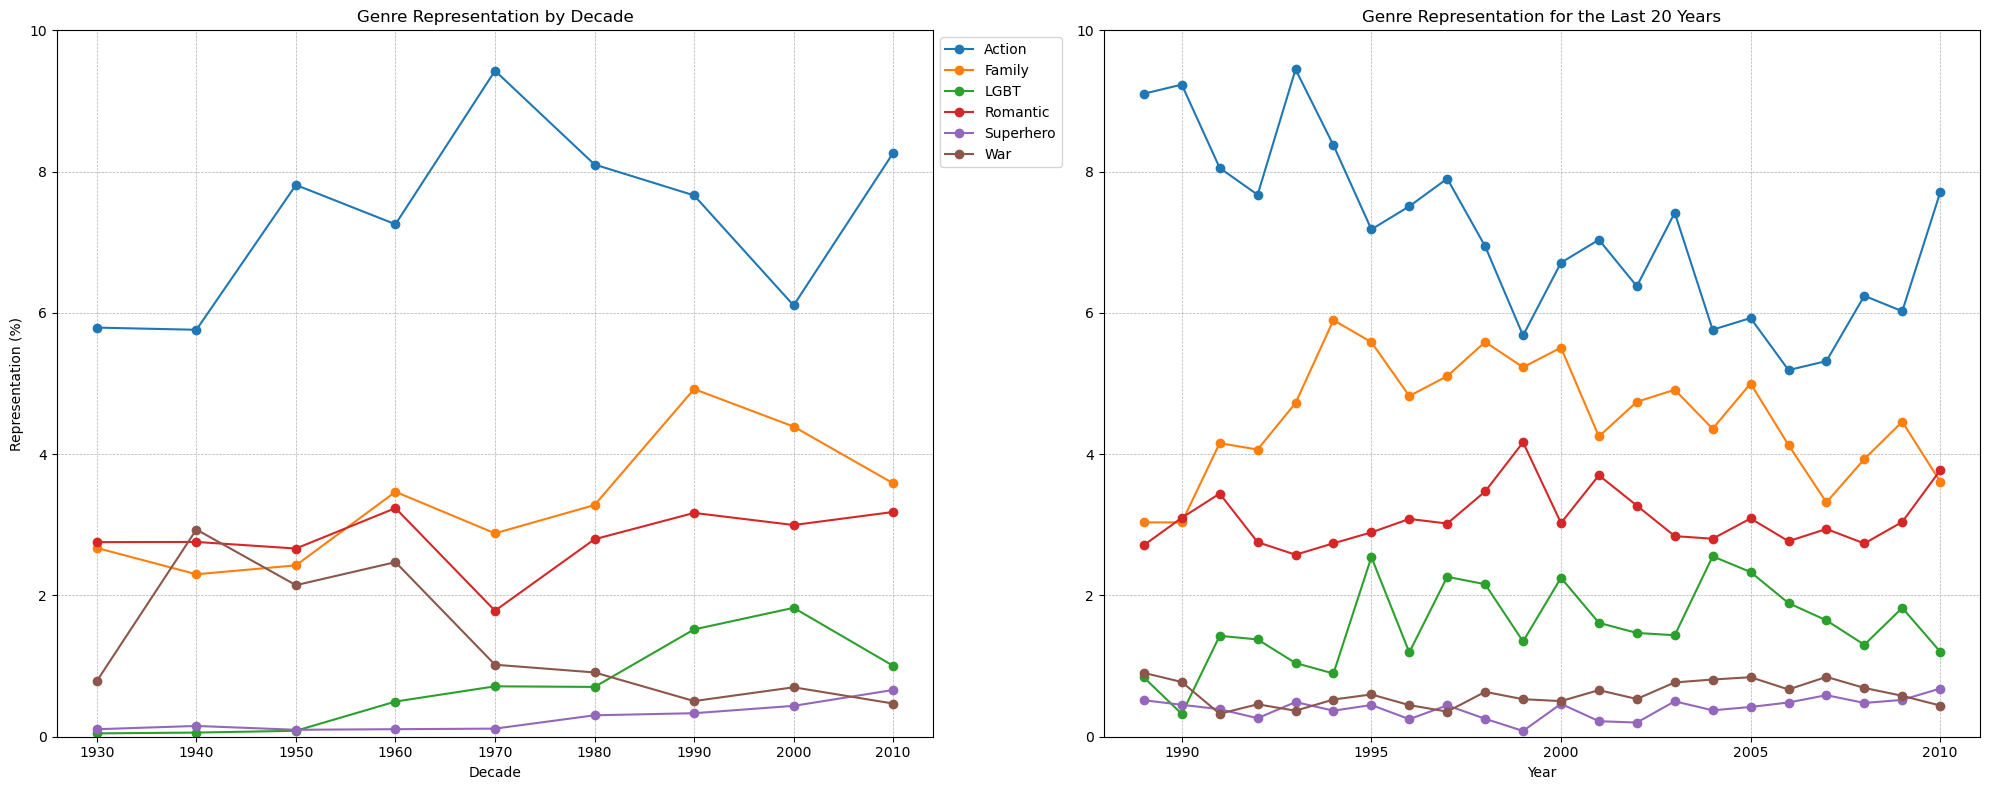

In [42]:
#We use the extended genres dataset
#Add the representation % to a dataframe after grouping and counting the occurences of each genre per decade. We start from 1929 as sample size is too small before that
df_genres_old = df_genres[df_genres['decade'] > 1929]
df_gen_old = df_genres_old.groupby(['decade', 'Movie genres']).size()
df_gen_old = df_gen_old.reset_index()
df_gen_old.columns = ['decade', 'Movie genres', 'count']
df_gen_old['total'] = df_gen_old.groupby('decade')['count'].transform('sum')
df_gen_old['percentage'] = (df_gen_old['count'] / df_gen_old['total']) * 100
df_gen_old['Movie genres'] = df_gen_old['Movie genres'].astype(str)

#Keep only genres we are interested in
df_gen_old = df_gen_old[df_gen_old['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Organize data
pivot_table_old = df_gen_old.pivot(index='decade', columns='Movie genres', values='percentage').fillna(0)


df_genres_new = df_genres[df_genres['Movie release year'] > 1988]
df_genres_new = df_genres_new[df_genres_new['Movie release year'] < 2011]

df_gen_new = df_genres_new.groupby(['Movie release year', 'Movie genres']).size()
df_gen_new = df_gen_new.reset_index()
df_gen_new.columns = ['Movie release year', 'Movie genres', 'count']
df_gen_new['total'] = df_gen_new.groupby('Movie release year')['count'].transform('sum')
df_gen_new['percentage'] = (df_gen_new['count'] / df_gen_new['total']) * 100
df_gen_new['Movie genres'] = df_gen_new['Movie genres'].astype(str)

#Keep only genres we are interested in
df_gen_new = df_gen_new[df_gen_new['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Organize data
pivot_table_new = df_gen_new.pivot(index='Movie release year', columns='Movie genres', values='percentage').fillna(0)


#Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

#Plot 1: genre representation by decade
pivot_table_old.plot(kind='line', ax=axes[0], marker='o')
axes[0].set_title("Genre Representation by Decade")
axes[0].set_xlabel("Decade")
axes[0].set_ylabel("Representation (%)")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axes[0].set_ylim(0, 10)

#Plot 2: genre representation for the last 20 years
pivot_table_new.plot(kind='line', ax=axes[1], marker='o')
axes[1].set_title("Genre Representation for the Last 20 Years")
axes[1].set_xlabel("Year")
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend_.remove()
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.savefig('visuals/20.png', bbox_inches='tight')
plt.show()

## Hypothesis 4: Some genres or themes are more popular and might draw more spectators


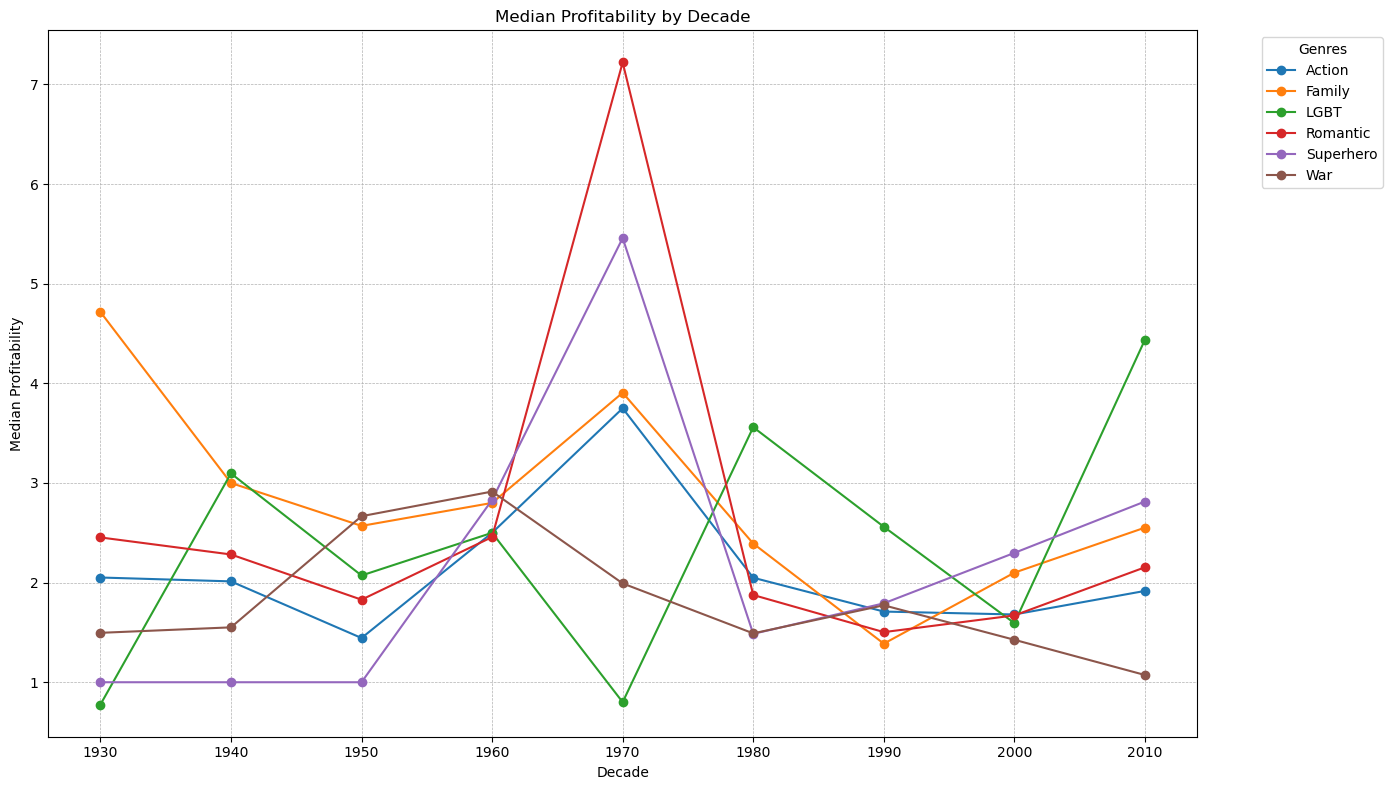

In [44]:
#We use the extended genres dataset
#Add the representation % to a dataframe after grouping and counting the occurences of each genre per decade. We start from 1929 as sample size is too small before that
df_genres__ = df_exploded[df_exploded['decade'] > 1929]
df_gen = df_genres__.groupby(['decade', 'Movie genres'])['profitability'].median().reset_index()
df_gen.columns = ['decade', 'Movie genres', 'median profitability']
df_gen['Movie genres'] = df_gen['Movie genres'].astype(str)

#Keep only genres we are interested in
df_gen = df_gen[df_gen['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Organize data
pivot_table = df_gen.pivot(index='decade', columns='Movie genres', values='median profitability').fillna(1)


#Plotting
pivot_table.plot(kind='line', figsize=(14, 8), marker='o')

plt.title("Median Profitability by Decade")
plt.xlabel("Decade")
plt.ylabel("Median Profitability")
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('visuals/21.png', bbox_inches='tight')
plt.show()


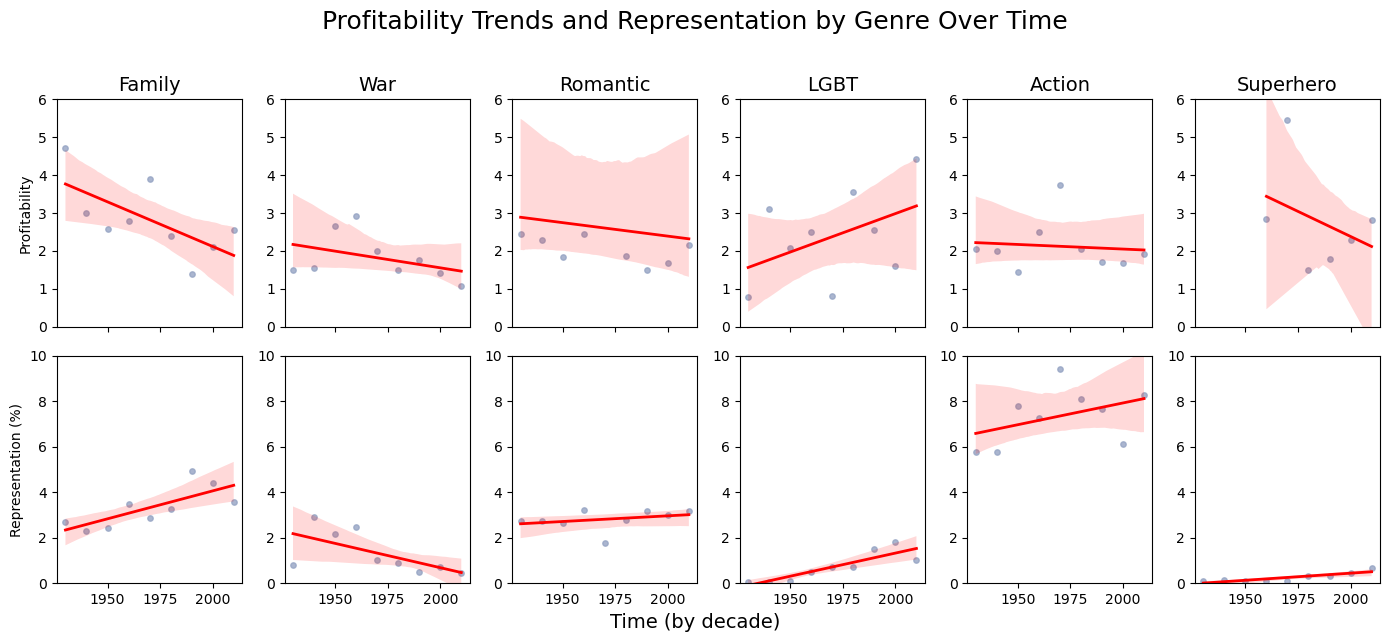

In [45]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over time, and how representation of movie genres 
# evolved over time for the last 100 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied genre
#Preparing data, keeping only data related to our genres and take the median profitability for each decade
df_genres_decade = df_exploded.groupby(['decade', 'Movie genres'])['profitability'].median().reset_index()
df_genres_decade = df_genres_decade[df_genres_decade['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_decade = df_genres_decade[df_genres_decade['decade'] > 1929]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[i]  
    theme_data = df_genres_decade[df_genres_decade['Movie genres'] == theme]
    sns.regplot(x='decade', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 6)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each genre by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our genres and compute how much each genre is represented across all genres in %
df_genres_pct = df_genres.groupby(['decade', 'Movie genres']).size().reset_index(name='count')
df_genres_pct = df_genres_pct[df_genres_pct['decade'] > 1929]
df_genres_pct['total'] = df_genres_pct.groupby('decade')['count'].transform('sum')
df_genres_pct['percentage'] = (df_genres_pct['count'] / df_genres_pct['total']) * 100
df_genres_pct = df_genres_pct[df_genres_pct['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[1 * n_cols + i] 
    theme_data = df_genres_pct[df_genres_pct['Movie genres'] == theme]
    sns.regplot(x='decade', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 10)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Genre Over Time", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.01, "Time (by decade)", ha='center', fontsize=14)
plt.savefig('visuals/profit_representation_by_genre.png', bbox_inches='tight')
plt.show()


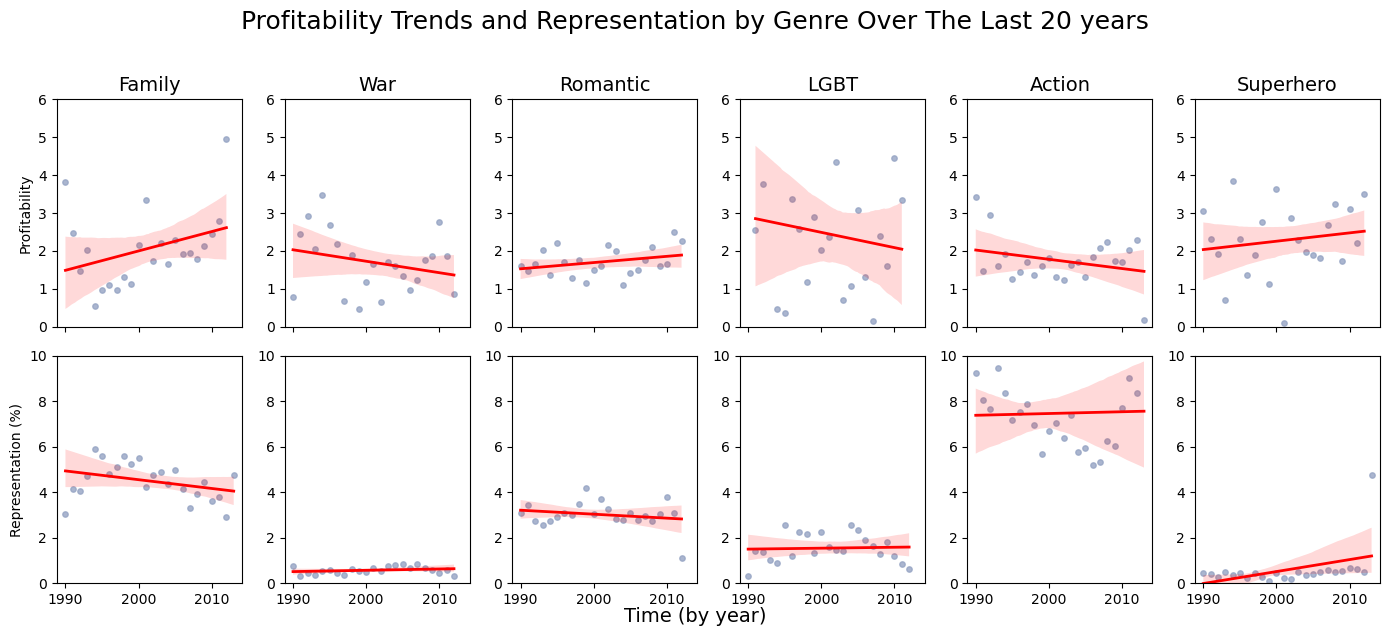

In [46]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over the last 20 years, and how representation of movie genres 
# evolved over time for the last 20 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied genre
#Preparing data, keeping only data related to our genres and take the median profitability for each decade
df_genres_decade = df_exploded.groupby(['Movie release year', 'Movie genres'])['profitability'].median().reset_index()
df_genres_decade = df_genres_decade[df_genres_decade['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_decade = df_genres_decade[df_genres_decade['Movie release year'] > 1989]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[i]  
    theme_data = df_genres_decade[df_genres_decade['Movie genres'] == theme]
    sns.regplot(x='Movie release year', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 6)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each genre by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our genres and compute how much each genre is represented across all genres in %
df_genres_pct = df_genres.groupby(['Movie release year', 'Movie genres']).size().reset_index(name='count')
df_genres_pct = df_genres_pct[df_genres_pct['Movie release year'] > 1989]
df_genres_pct['total'] = df_genres_pct.groupby('Movie release year')['count'].transform('sum')
df_genres_pct['percentage'] = (df_genres_pct['count'] / df_genres_pct['total']) * 100
df_genres_pct = df_genres_pct[df_genres_pct['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[1 * n_cols + i]  
    theme_data = df_genres_pct[df_genres_pct['Movie genres'] == theme]
    sns.regplot(x='Movie release year', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 10)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Genre Over The Last 20 years", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.00, "Time (by year)", ha='center', fontsize=14)
plt.savefig('visuals/profit_represention_of_genre_last_20_years.png', bbox_inches='tight')
plt.show()

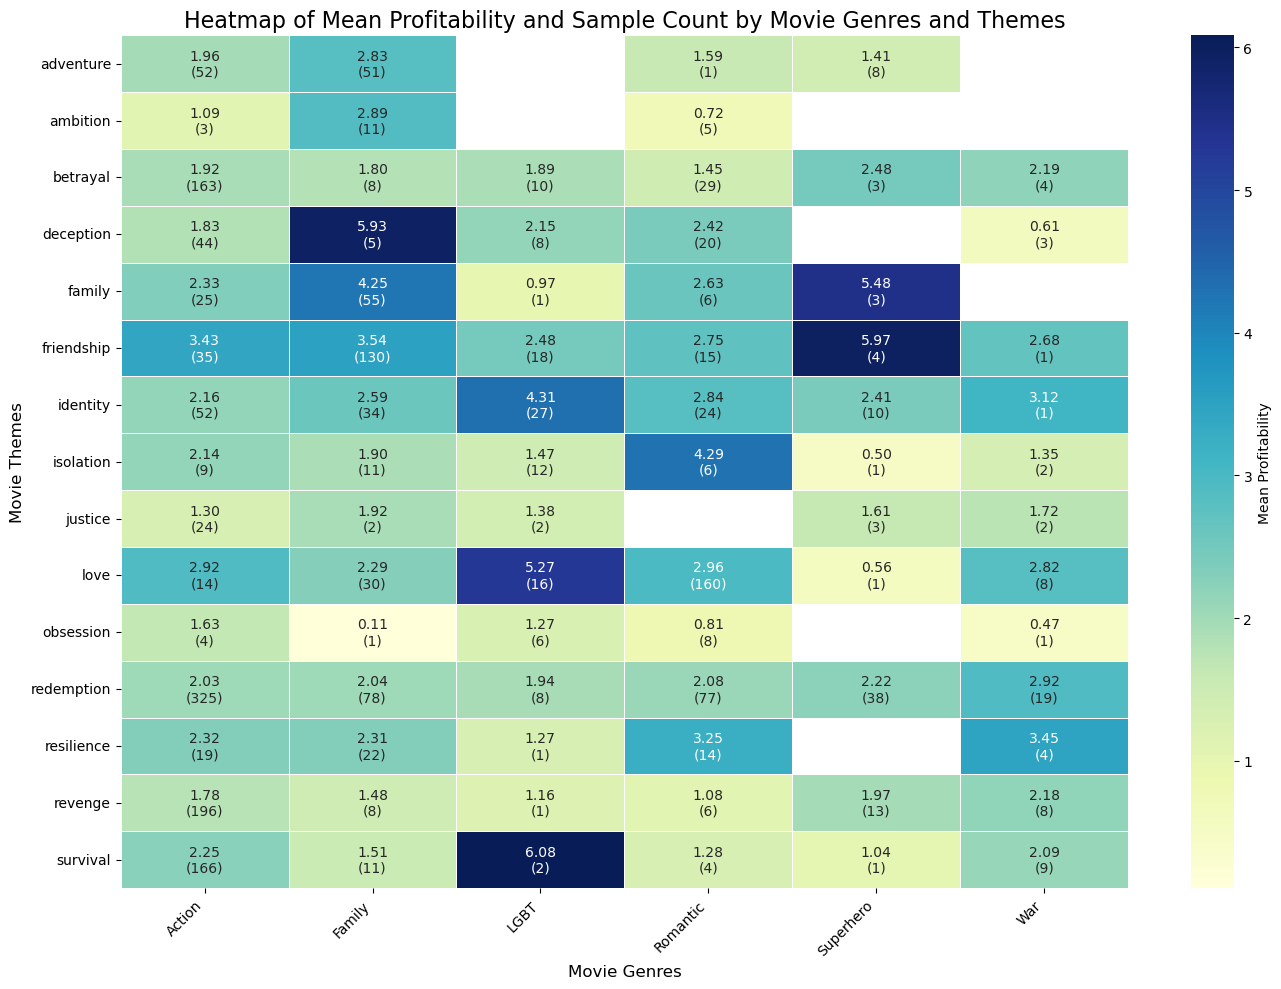

In [47]:
#Heatmap linking themes to genres, for profitability (including sample count between parenthesis)

#Prepare data of the last 20 years, keeping only the genres and themes we focus on
df_heatmap = df_exploded.copy()  
df_heatmap = df_heatmap[df_heatmap['decade'] > 1989] 
df_heatmap = df_heatmap[df_heatmap['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_heatmap = df_heatmap[df_heatmap['Theme'].isin(top_10_themes.index)].reset_index(drop=True)

#Get the mean profitability and sample size for each couple, organise it in a table. 
#Note : the sample sizes are smaller than previously, therefore we use the mean instead of median. ex. 0.5 3, 3 would overestimate profitability if not a lot of samples
df_aggregated = df_heatmap.groupby(['Movie genres', 'Theme']).agg(mean_profitability=('profitability', 'mean'), 
        sample_size=('profitability', 'size')).reset_index()

df_heatmap_mean = df_aggregated.pivot(index="Theme", columns="Movie genres", values="mean_profitability")
df_heatmap_count = df_aggregated.pivot(index="Theme", columns="Movie genres", values="sample_size")

#Combine mean profitability and sample count into a formatted str
annotations = pd.DataFrame("", index=df_heatmap_mean.index, columns=df_heatmap_mean.columns, dtype=object)
for row in annotations.index:
    for col in annotations.columns:
        mean = df_heatmap_mean.loc[row, col]
        count = df_heatmap_count.loc[row, col]
        if not pd.isna(mean) and not pd.isna(count):
            annotations.loc[row, col] = f"{mean:.2f}\n({int(count)})"

#Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_heatmap_mean, annot=annotations,  fmt="", cmap="YlGnBu",linewidths=0.5,cbar_kws={'label': 'Mean Profitability'})

plt.title("Heatmap of Mean Profitability and Sample Count by Movie Genres and Themes", fontsize=16)
plt.xlabel("Movie Genres", fontsize=12)
plt.ylabel("Movie Themes", fontsize=12)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig('visuals/heatmap_profit_genre_theme.png', bbox_inches='tight')
plt.show()

In [48]:
theme_list = ['friendship', 'resilience', 'identity', 'deception', 'love','family']

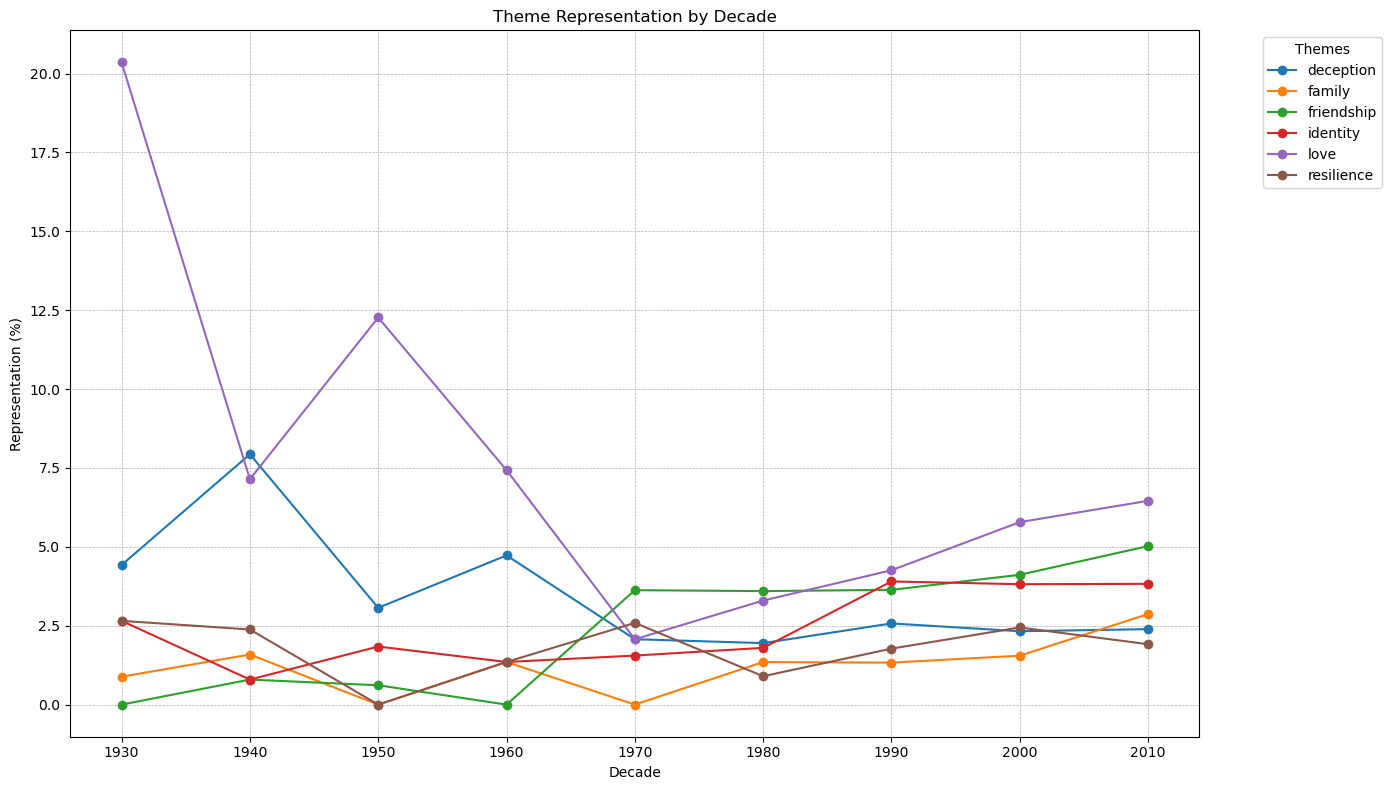

In [49]:
#We use the extended theme dataset
#Add the representation % to a dataframe after grouping and counting the occurences of each theme per decade. We start from 1929 as sample size is too small before that
df_theme_old = df_filtered[df_filtered['decade'] > 1929]
df_the_old = df_theme_old.groupby(['decade', 'Theme']).size()
df_the_old = df_the_old.reset_index()
df_the_old.columns = ['decade', 'Theme', 'count']
df_the_old['total'] = df_the_old.groupby('decade')['count'].transform('sum')
df_the_old['percentage'] = (df_the_old['count'] / df_the_old['total']) * 100
df_the_old['Theme'] = df_the_old['Theme'].astype(str)

#Keep only themes we are interested in
df_the_old = df_the_old[df_the_old['Theme'].isin(theme_list)].reset_index(drop=True)

#Organize data
pivot_table = df_the_old.pivot(index='decade', columns='Theme', values='percentage').fillna(0)


#Plotting
pivot_table.plot(kind='line', figsize=(14, 8), marker='o')

plt.title("Theme Representation by Decade")
plt.xlabel("Decade")
plt.ylabel("Representation (%)")
plt.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('visuals/25.png', bbox_inches='tight')
plt.show()

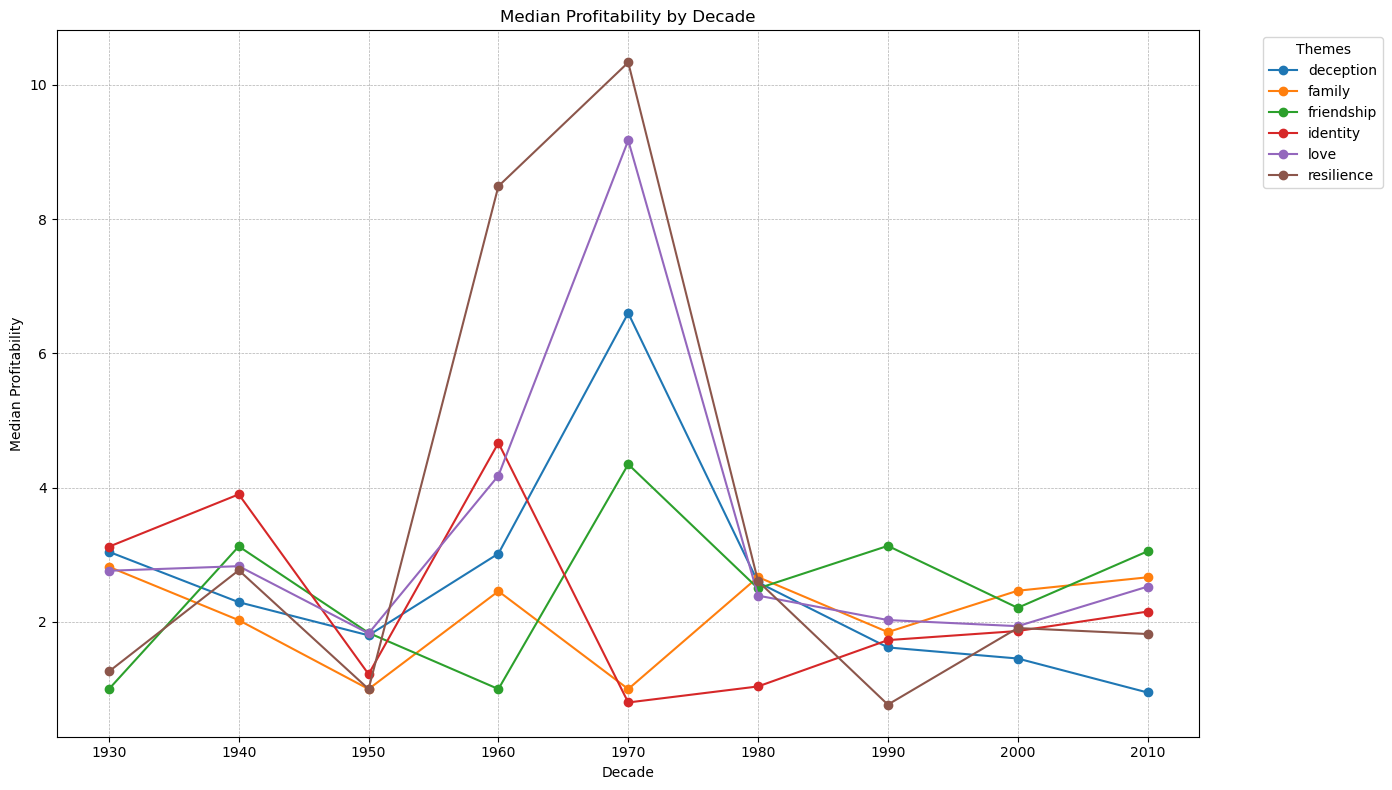

In [50]:
#We use the extended theme dataset
#Add the representation % to a dataframe after grouping and counting the occurences of each theme per decade. We start from 1929 as sample size is too small before that
df_theme__ = df_exploded[df_exploded['decade'] > 1929]
df_the = df_theme__.groupby(['decade', 'Theme'])['profitability'].median().reset_index()
df_the.columns = ['decade', 'Theme', 'median profitability']
df_the['Theme'] = df_the['Theme'].astype(str)

#Keep only themes we are interested in
df_the = df_the[df_the['Theme'].isin(theme_list)].reset_index(drop=True)

#Organize data
pivot_table = df_the.pivot(index='decade', columns='Theme', values='median profitability').fillna(1)


#Plotting
pivot_table.plot(kind='line', figsize=(14, 8), marker='o')

plt.title("Median Profitability by Decade")
plt.xlabel("Decade")
plt.ylabel("Median Profitability")
plt.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('visuals/26.png', bbox_inches='tight')
plt.show()

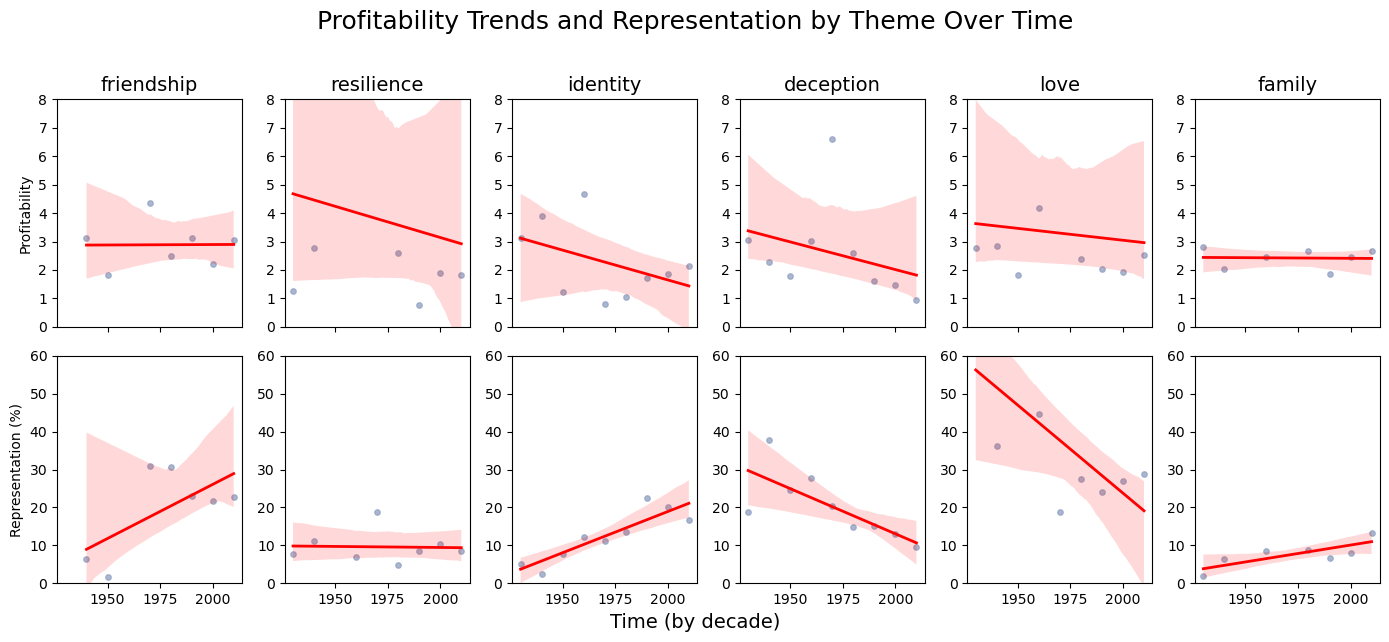

In [51]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over time, and how representation of movie themes 
# evolved over time for the last 100 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied theme
#Preparing data, keeping only data related to our themes and take the median profitability for each decade
df_theme_decade = df_exploded.groupby(['decade', 'Theme'])['profitability'].median().reset_index()
df_theme_decade = df_theme_decade[df_theme_decade['Theme'].isin(theme_list)].reset_index(drop=True)
df_theme_decade = df_theme_decade[df_theme_decade['decade'] > 1929]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(theme_list):
    ax = axes[i]  
    theme_data = df_theme_decade[df_theme_decade['Theme'] == theme]
    sns.regplot(x='decade', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 8)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each theme by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our themes and compute how much each theme is represented across all themes in %
df_theme_pct = df_exploded.groupby(['decade', 'Theme']).size().reset_index(name='count')
df_theme_pct = df_theme_pct[df_theme_pct['Theme'].isin(theme_list)].reset_index(drop=True)
df_theme_pct = df_theme_pct[df_theme_pct['decade'] > 1929]

df_theme_pct['total'] = df_theme_pct.groupby('decade')['count'].transform('sum')
df_theme_pct['percentage'] = (df_theme_pct['count'] / df_theme_pct['total']) * 100

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(theme_list):
    ax = axes[1 * n_cols + i] 
    theme_data = df_theme_pct[df_theme_pct['Theme'] == theme]
    sns.regplot(x='decade', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 60)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Theme Over Time", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.01, "Time (by decade)", ha='center', fontsize=14)
plt.savefig('visuals/profit_representation_by_theme.png', bbox_inches='tight')
plt.show()

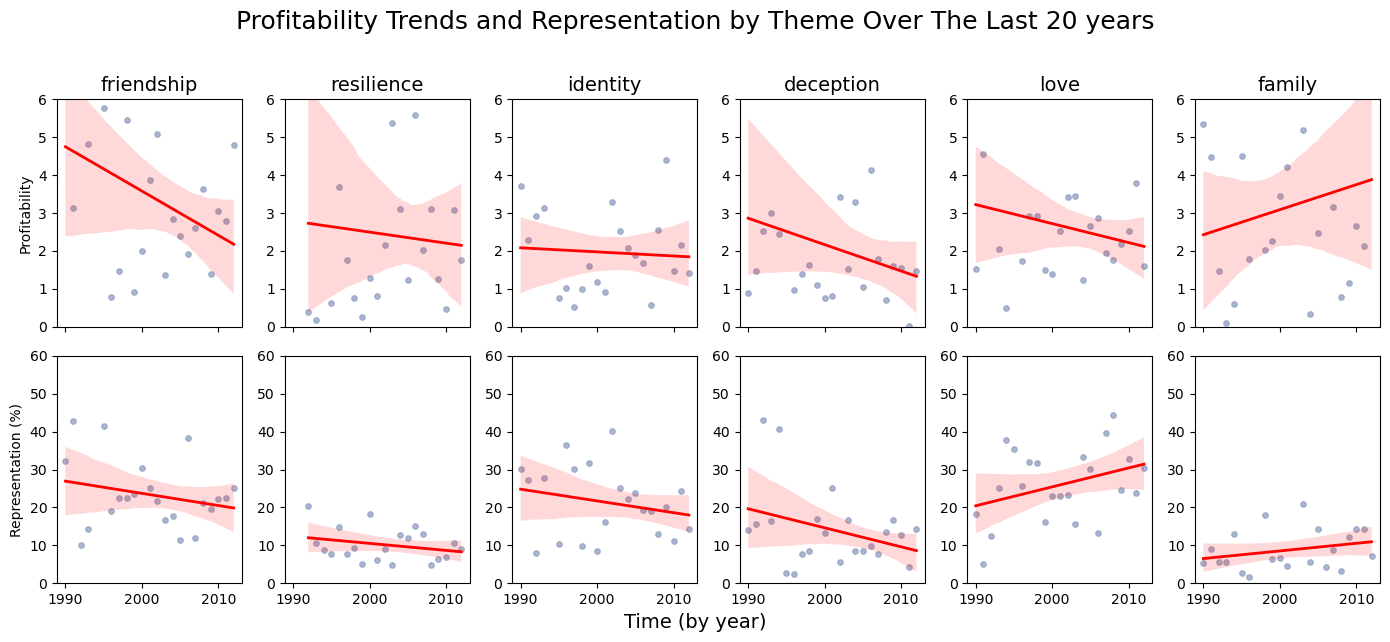

In [52]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over the last 20 years, and how representation of movie themes 
# evolved over time for the last 20 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied theme
#Preparing data, keeping only data related to our themes and take the median profitability for each decade
df_themes_decade = df_exploded.groupby(['Movie release year', 'Theme'])['profitability'].median().reset_index()
df_themes_decade = df_themes_decade[df_themes_decade['Theme'].isin(theme_list)].reset_index(drop=True)
df_themes_decade = df_themes_decade[df_themes_decade['Movie release year'] > 1989]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(theme_list):
    ax = axes[i]  
    theme_data = df_themes_decade[df_themes_decade['Theme'] == theme]
    sns.regplot(x='Movie release year', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 6)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each theme by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our themes and compute how much each theme is represented across all themes in %
df_theme_pct = df_exploded.groupby(['Movie release year', 'Theme']).size().reset_index(name='count')
df_theme_pct = df_theme_pct[df_theme_pct['Theme'].isin(theme_list)].reset_index(drop=True)
df_theme_pct = df_theme_pct[df_theme_pct['Movie release year'] > 1989]

df_theme_pct['total'] = df_theme_pct.groupby('Movie release year')['count'].transform('sum')
df_theme_pct['percentage'] = (df_theme_pct['count'] / df_theme_pct['total']) * 100

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(theme_list):
    ax = axes[1 * n_cols + i]  
    theme_data = df_theme_pct[df_theme_pct['Theme'] == theme]
    sns.regplot(x='Movie release year', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 60)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Theme Over The Last 20 years", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.01, "Time (by year)", ha='center', fontsize=14)
plt.savefig('visuals/profit_representation_by_theme_20_years.png', bbox_inches='tight')
plt.show()

## Combine the results

In [54]:
#Bubble chart representing the mean profitability for each month for each movie genre. The bubble sizes represent mean budget, sample count and mean runtime. 
#Note : the sample sizes are smaller than previously, therefore we use the mean instead of median. ex. 0.5 3, 3 would overestimate if very few samples

#Prepare data keeping only the last 20 years and genres we are interested in
df_bubbles = df_exploded.copy()  # Use your filtered dataset
df_bubbles = df_bubbles[df_bubbles['decade'] > 1989]  # Filter by decade
df_bubbles = df_bubbles[df_bubbles['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Group by genre and month, and get the mean profitability, budget, runtime and sample size.
df_aggregated = df_bubbles.groupby(['Movie genres', 'Movie release month']).agg(mean_profitability=('profitability', 'mean'), mean_budget=('budget', 'mean'),
    sample_size=('profitability', 'size'), mean_runtime=('Movie runtime', 'mean')).reset_index()

#For the display frmat hovering on bubbles only
df_aggregated['mean_runtime_display'] = df_aggregated['mean_runtime'].apply(lambda x: f"{x:.1f} min")
df_aggregated['mean_budget_display'] = df_aggregated['mean_budget'].apply(lambda x: f"${x / 1000000:.1f} M")

#Scale of the bubbles as we have 3 very different ranges (budget in millions, runtime in hunderds...)
def scale_sizes(values, min_size=8, max_size=27):
    min_val = np.min(values)
    max_val = np.max(values)
    if min_val == max_val:
        return np.full(len(values), (min_size + max_size) / 2)
    return min_size + (values - min_val) * ((max_size - min_size) / (max_val - min_val))

df_aggregated['runtime_scaled'] = scale_sizes(df_aggregated['mean_runtime'])
df_aggregated['sample_scaled'] = scale_sizes(df_aggregated['sample_size'])
df_aggregated['budget_scaled'] = scale_sizes(df_aggregated['mean_budget'])

#Creat figure
fig = px.scatter(df_aggregated, x="Movie release month", y="mean_profitability", color="Movie genres", size="budget_scaled", hover_name="Movie genres", 
            hover_data={
        "sample_size": ":.0f",
        "mean_budget_display": True,
        "mean_runtime_display": True,
        "mean_profitability": ":.1f",
        "Movie release month": True,
        "mean_budget": False,
        "Movie genres": False,
        "budget_scaled": False
    },
    labels={
        "mean_profitability": "Mean Profitability",
        "mean_budget_display": "Mean Budget",
        "Movie release month": "Release Month",
        "mean_runtime_display": "Mean Runtime"
    },
    title="Interactive Bubble Chart of Profitability by Release Month (Last 20 Years)",
    width=900,
    height=600)

#Names for x axis (to replace numerical months
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names[:12])

#Extract the ordered list of genres
trace_genres = [t.name for t in fig.data]

#For each genre, build marker size vectors to scale bubbles
ordered_budget_sizes = []
ordered_runtime_sizes = []
ordered_sample_sizes = []

for genre in trace_genres:
    subset = df_aggregated[df_aggregated['Movie genres'] == genre]
    subset = subset.sort_values(by='Movie release month')
    ordered_budget_sizes.append(subset['budget_scaled'].values)
    ordered_runtime_sizes.append(subset['runtime_scaled'].values)
    ordered_sample_sizes.append(subset['sample_scaled'].values)

#Create dropdown button with budget, runtime and sample size to change the bubble sizes accordingly
buttons = [
    dict(
        label="Bubble size: Mean Budget (1.5 to 223 M$)",
        method="restyle",
        args=[{"marker.size": ordered_budget_sizes}]
    ),
    dict(
        label="Bubble size: Mean Runtime (92 to 138 min)",
        method="restyle",
        args=[{"marker.size": ordered_runtime_sizes}]
    ),
    dict(
        label="Bubble size: Sample Size (3 to 182 samples)",
        method="restyle",
        args=[{"marker.size": ordered_sample_sizes}]
    )
]

fig.update_layout(
    legend_title="Movie Genres",
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.1,
            yanchor="top",
            buttons=buttons)])

fig.update_traces(marker=dict(sizemode='diameter', sizeref=0.5))
fig.write_html("visuals/29.html")
fig.show()


In [55]:
# General DataFrame and objects for this part
df_cs = df_movies.copy()

df_cs = df_cs.drop(['Movie release month', 'Movie release date', 'Movie runtime', 'Movie languages', 'Compound Score', 'season', 'Movie release day' ], axis=1)
df_cs = df_cs[df_cs['Movie countries'].apply(lambda x: 'United States of America' in x)]
df_cs = df_cs.dropna(subset=['Movie box office revenue','Movie release year'])

movies_per_year = df_cs.groupby('Movie release year').size()

box_office_per_year = df_cs.groupby('Movie release year')['Movie box office revenue'].median()

threshold = df_cs['Movie box office revenue'].quantile(0.99)
df_cs = df_cs[df_cs['Movie box office revenue'] <= threshold]

# DataFrame of war movies 
war_movies = df_cs[df_cs['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))]
print(f"Number of War Movies: {len(war_movies)}")

war_movies_per_year = war_movies.groupby('Movie release year').size()

# Align indexes
aligned_index = war_movies_per_year.index.intersection(movies_per_year.index)
war_movies_per_year = war_movies_per_year.loc[aligned_index]
movies_per_year = movies_per_year.loc[aligned_index]

Number of War Movies: 391


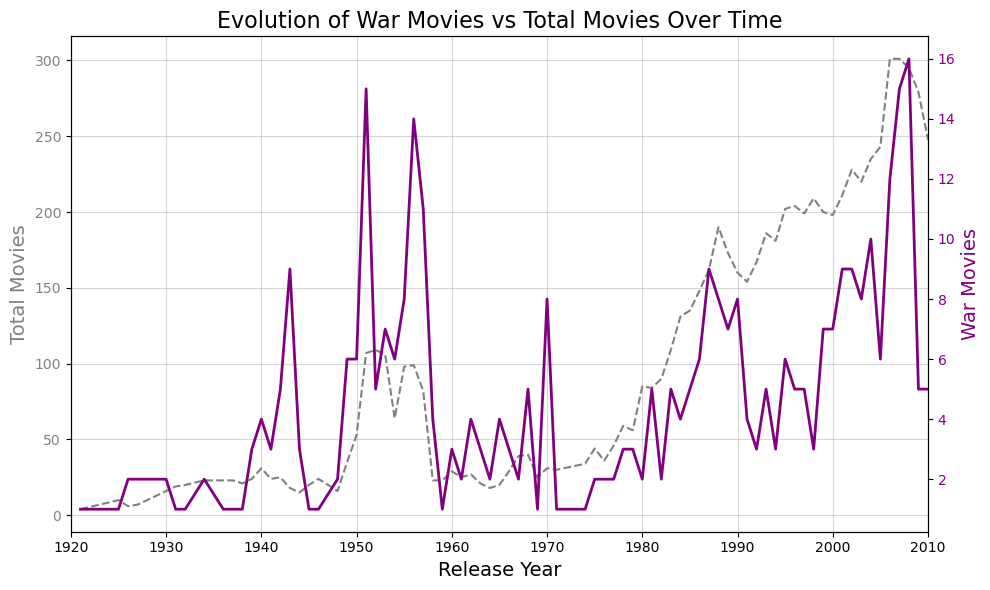

In [56]:
# Plot the number of War-related movies released over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies
ax1.plot(movies_per_year.index, movies_per_year.values, color='gray', linestyle='--', label='Total Movies')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot LGBT movies
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year.index, war_movies_per_year.values, color='purple', linewidth=2, label='LGBT Movies')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('visuals/war_movies_over_time.png')
plt.show()

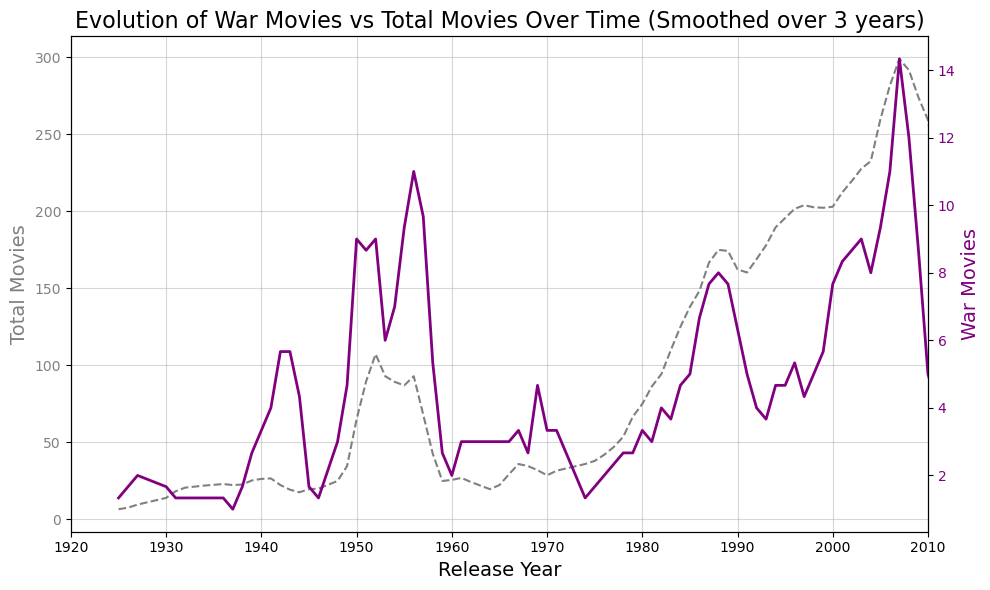

In [57]:
# Apply rolling average with a window of 3 years
war_movies_per_year_smooth = war_movies_per_year.rolling(window=3, center=True).mean()
movies_per_year_smooth = movies_per_year.rolling(window=3, center=True).mean()

# Plot the smoothed data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies (smoothed)
ax1.plot(movies_per_year_smooth.index, movies_per_year_smooth.values, color='gray', linestyle='--', label='Total Movies (Smoothed)')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot war movies (smoothed)
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year_smooth.index, war_movies_per_year_smooth.values, color='purple', linewidth=2, label='War Movies (Smoothed)')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add title and grid
plt.title('Evolution of War Movies vs Total Movies Over Time (Smoothed over 3 years)', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('visuals/31.png')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


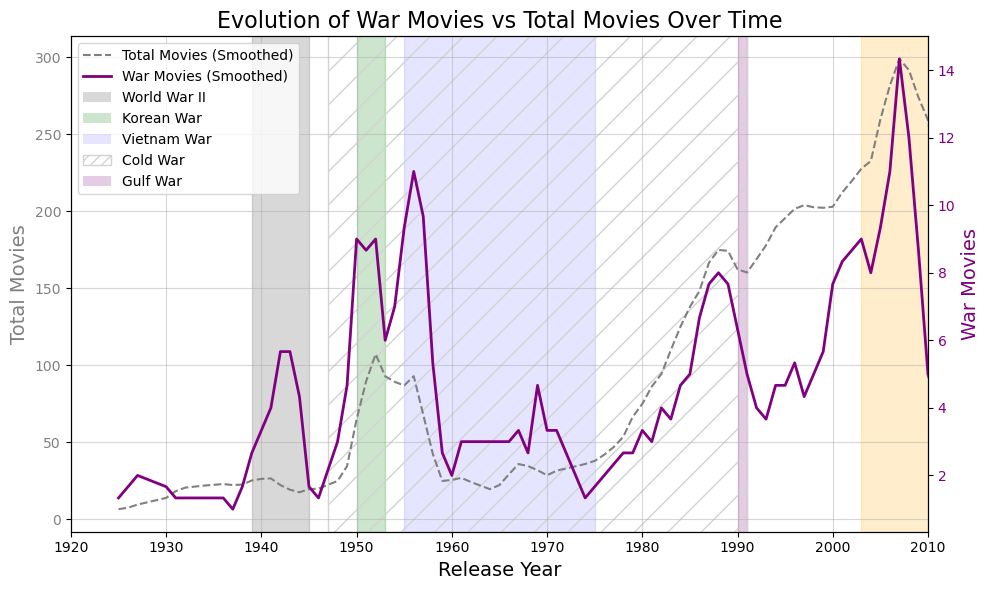

In [58]:
# Plot the smoothed data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies (smoothed)
ax1.plot(movies_per_year_smooth.index, movies_per_year_smooth.values, color='gray', linestyle='--', label='Total Movies (Smoothed)')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot war movies (smoothed)
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year_smooth.index, war_movies_per_year_smooth.values, color='purple', linewidth=2, label='War Movies (Smoothed)')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Annotate historical events
# WWII
ax1.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
ax1.text(1942, max(movies_per_year_smooth) * 0.9, 'WWII', color='black', fontsize=12)

# Korean War
ax1.axvspan(1950, 1953, color='green', alpha=0.2, label='Korean War')

# Vietnam War
ax1.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')

# Gulf War
ax1.axvspan(1990, 1991, color='purple', alpha=0.2, label='Gulf War')

# Iraq War
ax1.axvspan(2003, 2011, color='orange', alpha=0.2, label='Iraq War')

# Cold War 
ax1.axvspan(1947, 1991, facecolor='none', hatch='/', edgecolor='lightgray', label='Cold War')
ax1.text(1960, max(movies_per_year_smooth) * 0.8, 'Cold War', color='black', fontsize=12)

plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

legend_handles = [
    Line2D([0], [0], color='gray', linestyle='--', label='Total Movies (Smoothed)'),
    Line2D([0], [0], color='purple', linewidth=2, label='War Movies (Smoothed)'),
    Patch(facecolor='gray', alpha=0.3, label='World War II'),
    Patch(facecolor='green', alpha=0.2, label='Korean War'),
    Patch(facecolor='blue', alpha=0.1, label='Vietnam War'),
    Patch(facecolor='none', hatch='///', edgecolor='lightgray', label='Cold War'),
    Patch(facecolor='purple', alpha=0.2, label='Gulf War')
]
ax1.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('visuals/war_movies_over_time_smoothed.png')
plt.show()


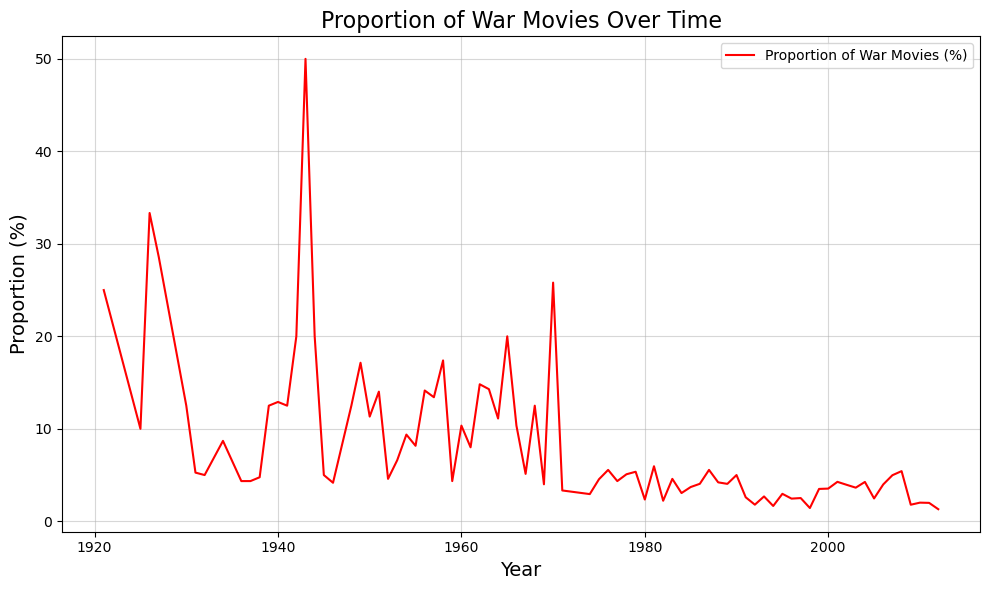

In [59]:
# Compute the proportion
war_movies_perc = (war_movies_per_year / movies_per_year) * 100

# Plot the proportion
plt.figure(figsize=(10, 6))
plt.plot(war_movies_per_year.index, war_movies_perc, label='Proportion of War Movies (%)', color='red')
plt.title("Proportion of War Movies Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Proportion (%)", fontsize=14)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('visuals/war_movies_proportion_over_time.png')
plt.show()

In [60]:
# Calculate Pearson correlation
corr, p_value = pearsonr(war_movies_per_year, movies_per_year)

# Save variables to a file
with open('results/pearson_war.pkl', 'wb') as file:
    pickle.dump({'corr': corr, 'p_value': p_value}, file)

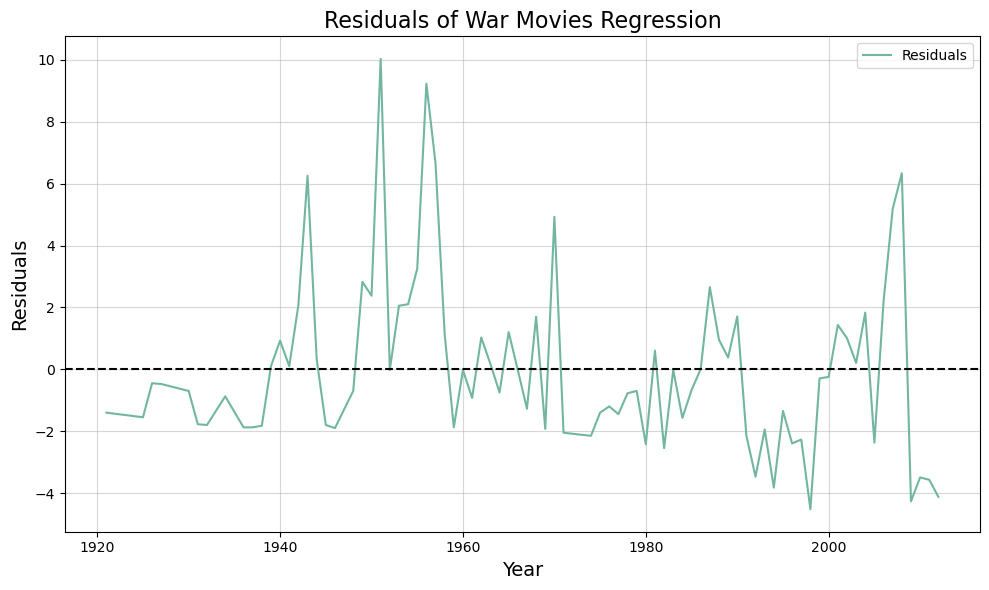

In [61]:
#OSL Regression

# Prepare data for regression
X = sm.add_constant(movies_per_year)  # Add constant for intercept
y = war_movies_per_year

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Save the summary to a text file
with open('results/OSL_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

# Compute residuals
residuals = y - model.predict(X)

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(war_movies_per_year.index, residuals, label='Residuals', color='#72b6a1')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of War Movies Regression", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('visuals/OSL_war_movies.png')
plt.show()

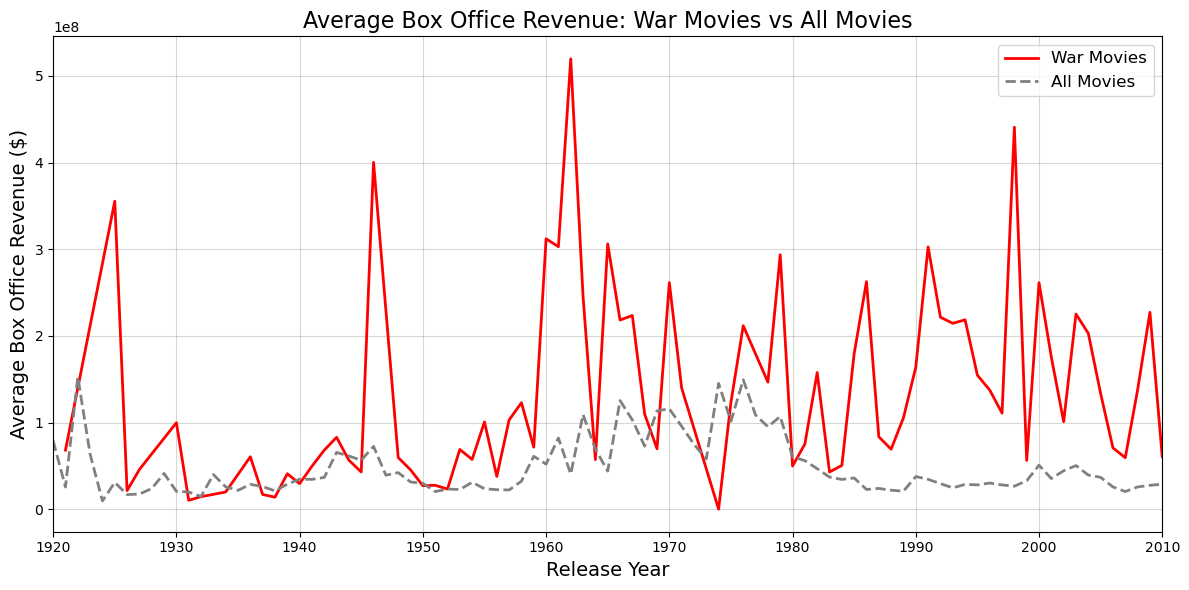

In [62]:
# Group by year and calculate average box office revenue for war movies
war_movies_box_office_per_year = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_per_year.index, war_movies_box_office_per_year.values, label='War Movies', color='red', linewidth=2)
plt.plot(box_office_per_year.index, box_office_per_year.values, label='All Movies', color='gray', linestyle='--', linewidth=2)
plt.title('Average Box Office Revenue: War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('visuals/35.png')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

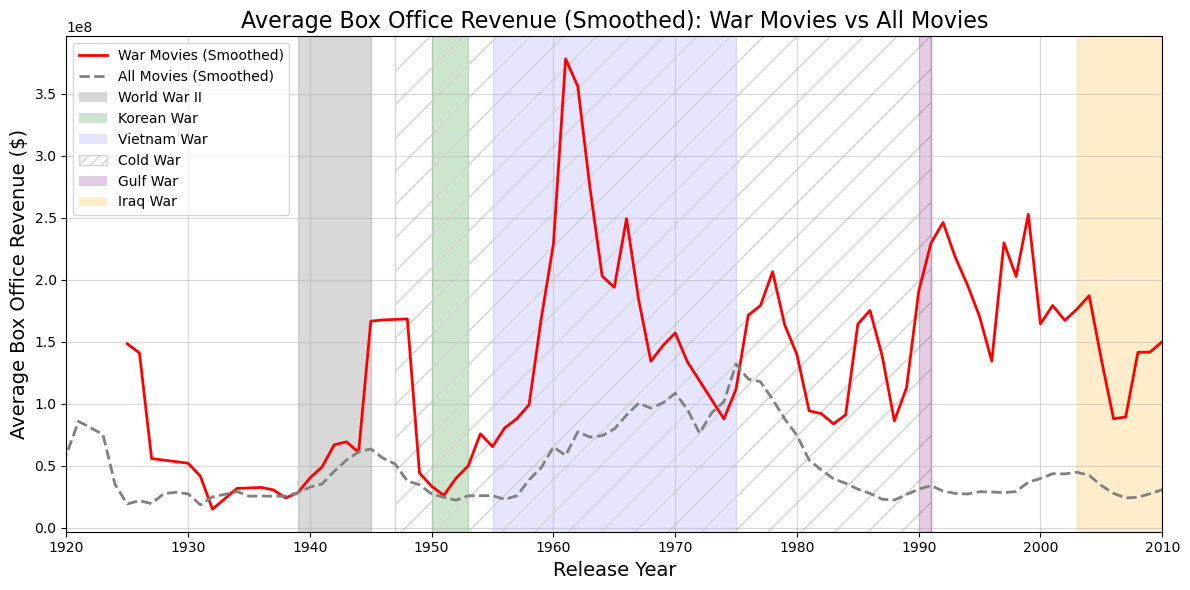

In [63]:
# Apply rolling average with a window of 3 years
war_movies_box_office_smooth = war_movies_box_office_per_year.rolling(window=3, center=True).mean()
box_office_smooth = box_office_per_year.rolling(window=3, center=True).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_smooth.index, war_movies_box_office_smooth.values, label='War Movies (Smoothed)', color='red', linewidth=2)
plt.plot(box_office_smooth.index, box_office_smooth.values, label='All Movies (Smoothed)', color='gray', linestyle='--', linewidth=2)

# Annotate historical events
plt.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
plt.text(1942, max(box_office_smooth) * 0.9, 'WWII', color='black', fontsize=12)

plt.axvspan(1950, 1953, color='green', alpha=0.2, label='Korean War')
plt.text(1951, max(box_office_smooth) * 0.8, 'Korean War', color='black', fontsize=12)

plt.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')
plt.text(1965, max(box_office_smooth) * 0.7, 'Vietnam War', color='black', fontsize=12)

plt.axvspan(1947, 1991, facecolor='none', hatch='/', edgecolor='lightgray', label='Cold War')
plt.text(1960, max(box_office_smooth) * 0.6, 'Cold War', color='lightgray', fontsize=12)

plt.axvspan(1990, 1991, color='purple', alpha=0.2, label='Gulf War')
plt.text(1990.5, max(box_office_smooth) * 0.5, 'Gulf War', color='black', fontsize=12)

plt.axvspan(2003, 2011, color='orange', alpha=0.2, label='Iraq War')
plt.text(2007, max(box_office_smooth) * 0.4, 'Iraq War', color='black', fontsize=12)

plt.title('Average Box Office Revenue (Smoothed): War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.grid(alpha=0.5)

legend_handles = [
    Line2D([0], [0], color='red', linewidth=2, label='War Movies (Smoothed)'),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=2, label='All Movies (Smoothed)'),
    Patch(facecolor='gray', alpha=0.3, label='World War II'),
    Patch(facecolor='green', alpha=0.2, label='Korean War'),
    Patch(facecolor='blue', alpha=0.1, label='Vietnam War'),
    Patch(facecolor='none', hatch='///', edgecolor='lightgray', label='Cold War'),
    Patch(facecolor='purple', alpha=0.2, label='Gulf War'),
    Patch(facecolor='orange', alpha=0.2, label='Iraq War'),
]
plt.legend(handles=legend_handles, fontsize=10, loc='upper left')

plt.tight_layout()
plt.savefig('visuals/war_movies_BO.png')
plt.show()


**Superheros**

In [65]:
superhero_movies = df_cs[df_cs['Movie genres'].apply(lambda genres: any(g in genres for g in superhero_genres))]

In [66]:
# Identify overlapping movies
overlapping_movies = df_cs[df_cs['Movie genres'].apply(lambda genres: 
    any(g in genres for g in superhero_genres) and any(g in genres for g in war_genres))]

overlapping_movies

Unnamed: 0 Movie name  Movie release year  \
Wikipedia movie ID                                              
5676692                  46612   Iron Man              2008.0   

                    Movie box office revenue               Movie countries  \
Wikipedia movie ID                                                           
5676692                         8.586565e+08  ['United States of America']   

                                                         Movie genres  \
Wikipedia movie ID                                                      
5676692             [Thriller, Science Fiction, Superhero movie, A...   

                                                              Summary  \
Wikipedia movie ID                                                      
5676692             Playboy and genius Tony Stark, who has inherit...   

                   Sentiment  vote_average        budget       Theme  decade  
Wikipedia movie ID                                                            
5676692             negative          7.64  2.054293e+08  redemption  2000.0

In [67]:
# Remove the movie from war_movies
war_movies = war_movies.drop(index=5676692, errors='ignore')

In [68]:
# Group by release year and count movies
superhero_movies_per_year = superhero_movies.groupby('Movie release year').size()
war_movies_per_year = war_movies.groupby('Movie release year').size()
total_movies_per_year = df_cs.groupby('Movie release year').size()

# Normalize by total movies released each year
superhero_movies_norm = superhero_movies_per_year / total_movies_per_year
war_movies_norm = war_movies_per_year / total_movies_per_year

# Smooth data using rolling average
superhero_movies_smooth = superhero_movies_norm.rolling(window=3, center=True).mean()
war_movies_smooth = war_movies_norm.rolling(window=3, center=True).mean()

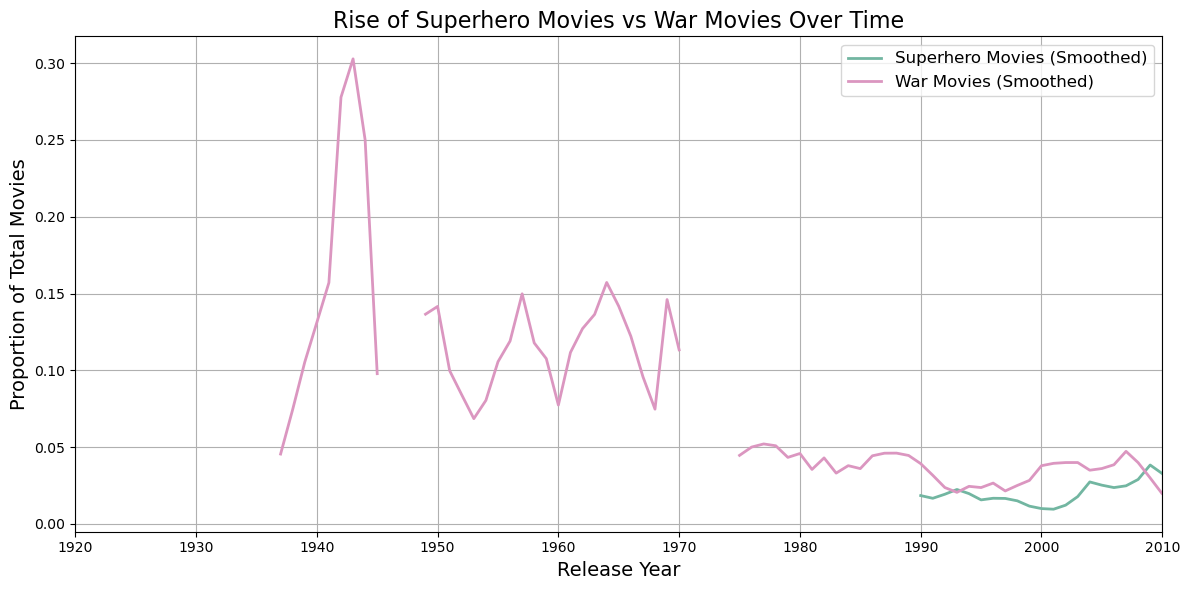

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(superhero_movies_smooth.index, superhero_movies_smooth.values, label='Superhero Movies (Smoothed)', color='#72b6a1', linewidth=2)
plt.plot(war_movies_smooth.index, war_movies_smooth.values, label='War Movies (Smoothed)', color='#db96c0', linewidth=2)

plt.title('Rise of Superhero Movies vs War Movies Over Time', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion of Total Movies', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=1)
plt.tight_layout()
plt.savefig('visuals/37.png')
plt.show()

In [70]:
# Align data for correlation analysis
aligned_data = pd.DataFrame({
    'superhero': superhero_movies_smooth,
    'war': war_movies_smooth
}).dropna()

# Correlation test
corr, p_value = pearsonr(aligned_data['superhero'], aligned_data['war'])

# Save variables to a file
with open('results/pearson_superhero.pkl', 'wb') as file:
    pickle.dump({'corr': corr, 'p_value': p_value}, file)

In [71]:
# Group by release year and calculate average box office revenue
superhero_box_office = superhero_movies.groupby('Movie release year')['Movie box office revenue'].mean()
war_box_office = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Apply rolling average
superhero_box_office_smooth = superhero_box_office.rolling(window=3, center=True).mean()
war_box_office_smooth = war_box_office.rolling(window=3, center=True).mean()

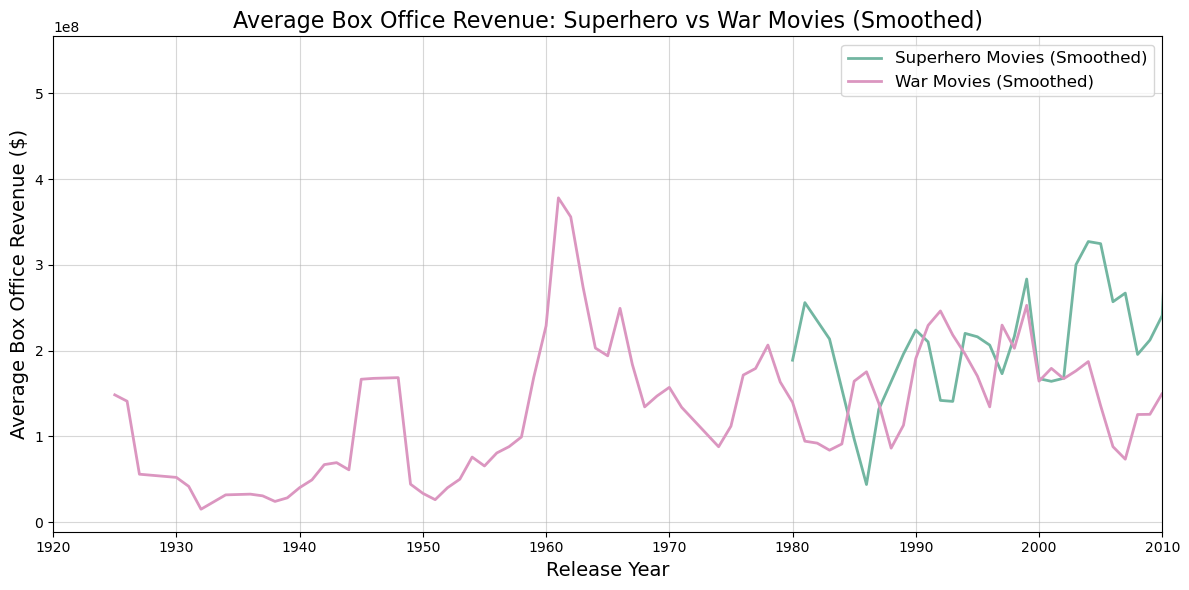

In [72]:
# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(superhero_box_office_smooth.index, superhero_box_office_smooth.values, label='Superhero Movies (Smoothed)', color='#72b6a1', linewidth=2)
plt.plot(war_box_office_smooth.index, war_box_office_smooth.values, label='War Movies (Smoothed)', color='#db96c0', linewidth=2)

# Add title, labels, and legend
plt.title('Average Box Office Revenue: Superhero vs War Movies (Smoothed)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('visuals/38.png')
plt.show()

In [73]:
#Let's limit the period to 1980-2010
start_year = 1980
end_year = 2010

# Filter the main DataFrame
df_cs_filtered = df_cs[(df_cs['Movie release year'] >= start_year) & (df_cs['Movie release year'] <= end_year)]

# Filter war movies
war_movies_filtered = war_movies[(war_movies['Movie release year'] >= start_year) & (war_movies['Movie release year'] <= end_year)]

# Filter superhero movies
superhero_movies_filtered = superhero_movies[(superhero_movies['Movie release year'] >= start_year)& (superhero_movies['Movie release year'] <= end_year)]

# Group by release year and count movies
superhero_movies_per_year = superhero_movies_filtered.groupby('Movie release year').size()
war_movies_per_year = war_movies_filtered.groupby('Movie release year').size()
total_movies_per_year = df_filtered.groupby('Movie release year').size()

# Normalize by total movies released each year
superhero_movies_norm = superhero_movies_per_year / total_movies_per_year
war_movies_norm = war_movies_per_year / total_movies_per_year


# Group by release year and calculate average box office revenue
superhero_box_office = superhero_movies_filtered.groupby('Movie release year')['Movie box office revenue'].mean()
war_box_office = war_movies_filtered.groupby('Movie release year')['Movie box office revenue'].mean()

# Smooth data using rolling average
superhero_movies_smooth = superhero_movies_norm.rolling(window=3, center=True).mean()
war_movies_smooth = war_movies_norm.rolling(window=3, center=True).mean()

# Smooth data using rolling average
superhero_box_office_smooth = superhero_box_office.rolling(window=3, center=True).mean()
war_box_office_smooth = war_box_office.rolling(window=3, center=True).mean()

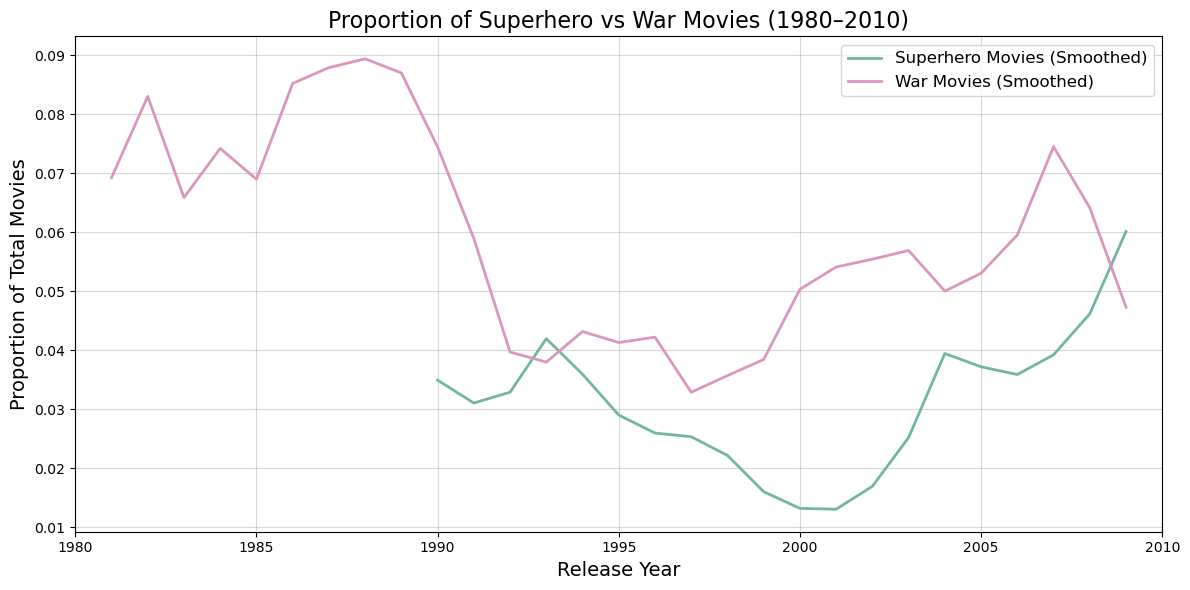

In [74]:
# Plot smoothed trends for counts
plt.figure(figsize=(12, 6))
plt.plot(superhero_movies_smooth.index, superhero_movies_smooth.values, label='Superhero Movies (Smoothed)', color='#72b6a1', linewidth=2)
plt.plot(war_movies_smooth.index, war_movies_smooth.values, label='War Movies (Smoothed)', color='#db96c0', linewidth=2)

# Add title and labels
plt.title('Proportion of Superhero vs War Movies (1980–2010)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion of Total Movies', fontsize=14)
plt.xlim(start_year, end_year)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('visuals/superheros_war.png')
plt.show()

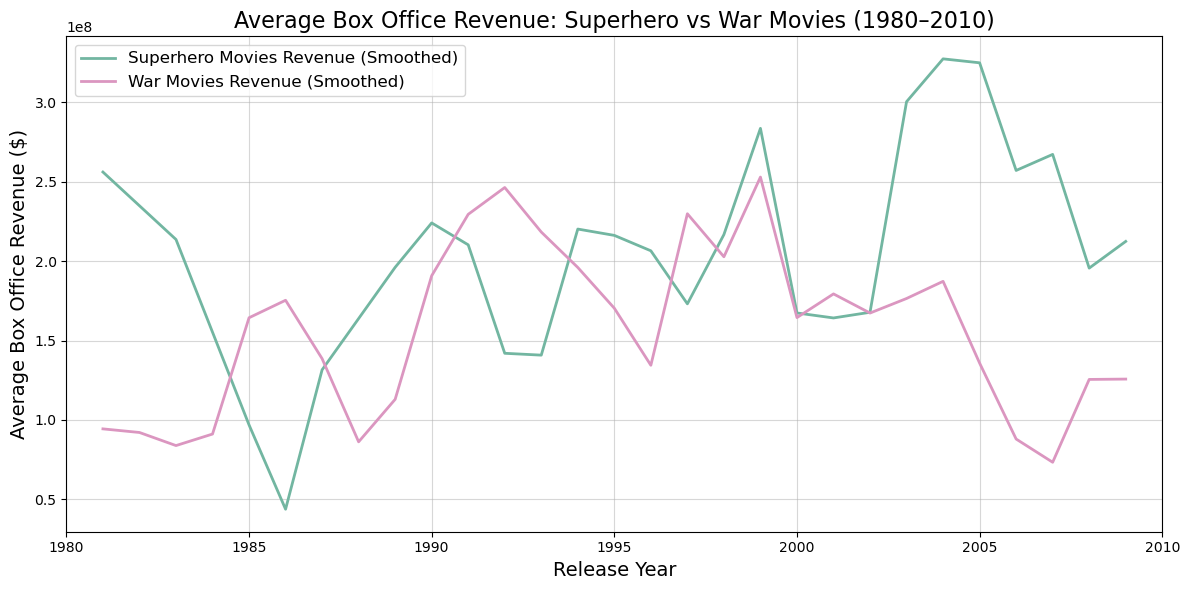

In [75]:
# Plot smoothed trends for box office revenue
plt.figure(figsize=(12, 6))
plt.plot(superhero_box_office_smooth.index, superhero_box_office_smooth.values, label='Superhero Movies Revenue (Smoothed)', color='#72b6a1', linewidth=2)
plt.plot(war_box_office_smooth.index, war_box_office_smooth.values, label='War Movies Revenue (Smoothed)', color='#db96c0', linewidth=2)

# Add title and labels
plt.title('Average Box Office Revenue: Superhero vs War Movies (1980–2010)', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(start_year, end_year)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('visuals/superheros_war_BO.png')
plt.show()

In [76]:
# Drop NaN values
superhero_revenue = superhero_box_office.dropna()
war_revenue = war_box_office.dropna()

# Perform t-test
t_stat, p_value = ttest_ind(superhero_revenue, war_revenue, equal_var=False)

# Save variables to a file
with open('results/t_superhero.pkl', 'wb') as file:
    pickle.dump({'t_stat': t_stat, 'p_value': p_value}, file)

**Themes analysis**

In [78]:
# Explode the themes for each movie
war_movies_exploded = war_movies.copy()
war_movies_exploded['Theme'] = war_movies_exploded['Theme'].str.split(',')
war_movies_exploded = war_movies_exploded.explode('Theme').dropna(subset=['Theme'])
war_movies_exploded['Theme'] = war_movies_exploded['Theme'].str.strip()

superhero_movies_exploded = superhero_movies.copy()
superhero_movies_exploded['Theme'] = superhero_movies_exploded['Theme'].str.split(',')
superhero_movies_exploded = superhero_movies_exploded.explode('Theme').dropna(subset=['Theme'])
superhero_movies_exploded['Theme'] = superhero_movies_exploded['Theme'].str.strip()

# Count themes per decade
war_themes_per_decade = war_movies_exploded.groupby(['decade', 'Theme']).size().unstack(fill_value=0)
superhero_themes_per_decade = superhero_movies_exploded.groupby(['decade', 'Theme']).size().unstack(fill_value=0)

# Normalize theme frequencies
war_themes_normalized = war_themes_per_decade.div(war_themes_per_decade.sum(axis=1), axis=0)
superhero_themes_normalized = superhero_themes_per_decade.div(superhero_themes_per_decade.sum(axis=1), axis=0)

# Calculate total frequency for each theme across all decades
total_war_theme_frequency = war_themes_normalized.sum(axis=0)

# Select the top 10 themes by total frequency
top_10_war_themes = total_war_theme_frequency.nlargest(10).index

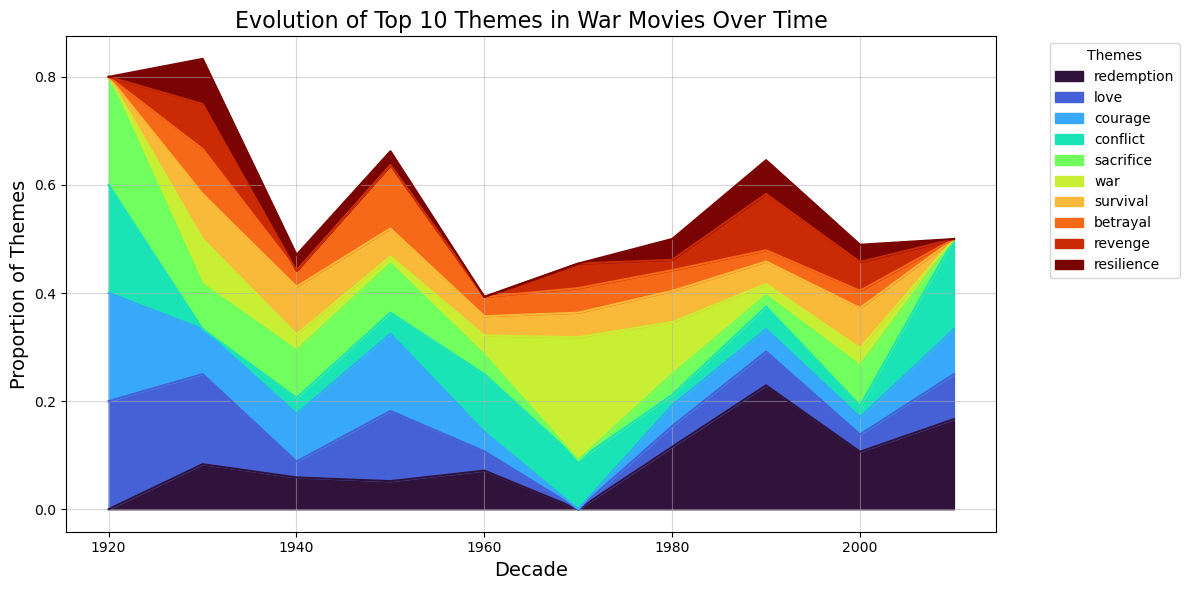

In [79]:
# Plot stacked area chart for war movies
war_themes_normalized_top10 = war_themes_normalized[war_themes_normalized.columns[:10]]  # Top 10 themes
# Filter war themes for the top 10
war_themes_normalized_top10 = war_themes_normalized[top_10_war_themes]

war_themes_normalized_top10.plot(kind='area', stacked=True, figsize=(12, 6), colormap='turbo')

plt.title('Evolution of Top 10 Themes in War Movies Over Time', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Proportion of Themes', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(title='Themes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('visuals/war_themes.png')
plt.show()

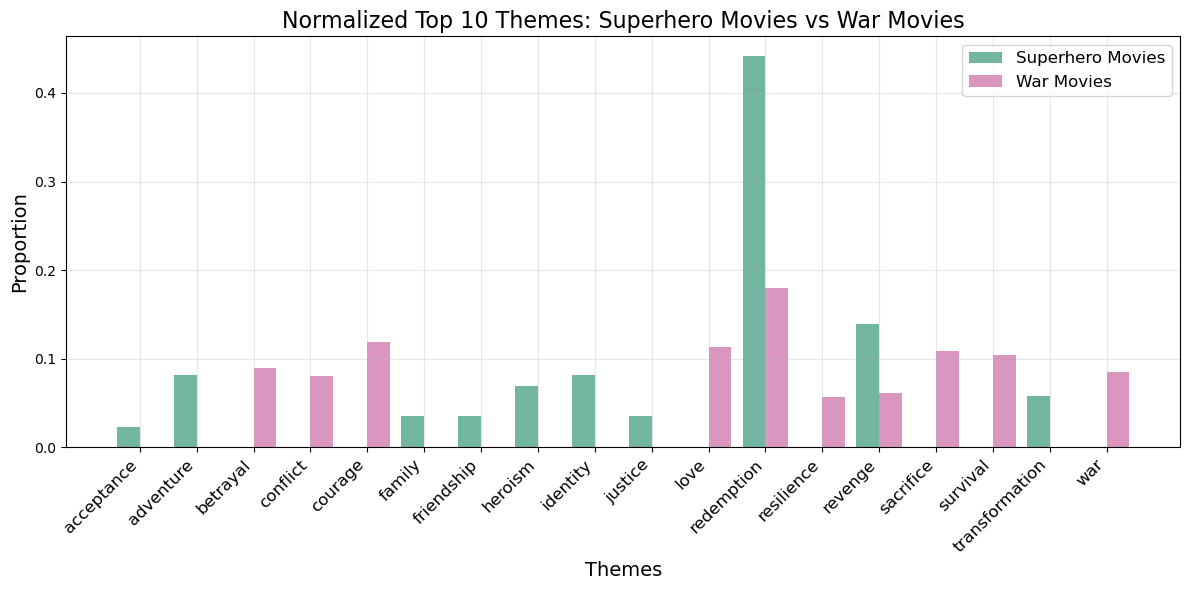

In [80]:
# Compute total frequency of themes for superhero movies
superhero_theme_counts = superhero_themes_per_decade.sum(axis=0)
top_10_superhero_themes = superhero_theme_counts.nlargest(10)

# Compute total frequency of themes for war movies
war_theme_counts = war_themes_per_decade.sum(axis=0)
top_10_war_themes = war_theme_counts.nlargest(10)

# Normalize the theme counts
normalized_comparison_df = pd.DataFrame({
    'Superhero Movies': top_10_superhero_themes / top_10_superhero_themes.sum(),
    'War Movies': top_10_war_themes / top_10_war_themes.sum()
}).fillna(0)  # Fill missing values with 0

# Define bar positions
x = np.arange(len(normalized_comparison_df.index))  # Position for themes
width = 0.4  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Superhero movies bar
ax.bar(
    x - width/2,
    normalized_comparison_df['Superhero Movies'],
    width,
    label='Superhero Movies',
    color='#72b6a1'
)

# War movies bar
ax.bar(
    x + width/2,
    normalized_comparison_df['War Movies'],
    width,
    label='War Movies',
    color='#db96c0'
)

# Add labels, title, and legend
ax.set_title('Normalized Top 10 Themes: Superhero Movies vs War Movies', fontsize=16)
ax.set_xlabel('Themes', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(normalized_comparison_df.index, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visuals/superheros_war_themes.png')
plt.show()